# Data Analysis

In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import os  
import shutil
import random
from sklearn.metrics import mean_squared_error
import scipy.stats as st 
import tqdm
import pickle

plt.rcParams['figure.dpi'] = 200
plt.rcParams['savefig.dpi'] = 600
plt.style.use('ggplot')
random.seed(100)

## Importing the Data

In [2]:
wd = os.getcwd() 
path = os.path.join(os.path.join(wd, "data"), "TSVs")
job = "9000841.amn-0001"
num = "1"
file = os.path.join(os.path.join(os.path.join(path, job), num), "predicted.tsv")
file

'/Users/jakegwinn/Documents/argonne/data/TSVs/9000841.amn-0001/1/predicted.tsv'

In [3]:
data = pd.read_csv(file, sep="\t")

How Many Files are there?

In [4]:
count = 0
for subdir, dirs, files in os.walk(path):
    for file in files:
        # print(os.path.join(subdir, file))
        count += 1
print(count)

1884


## EDA

### Initial Plot

<AxesSubplot: ylabel='Frequency'>

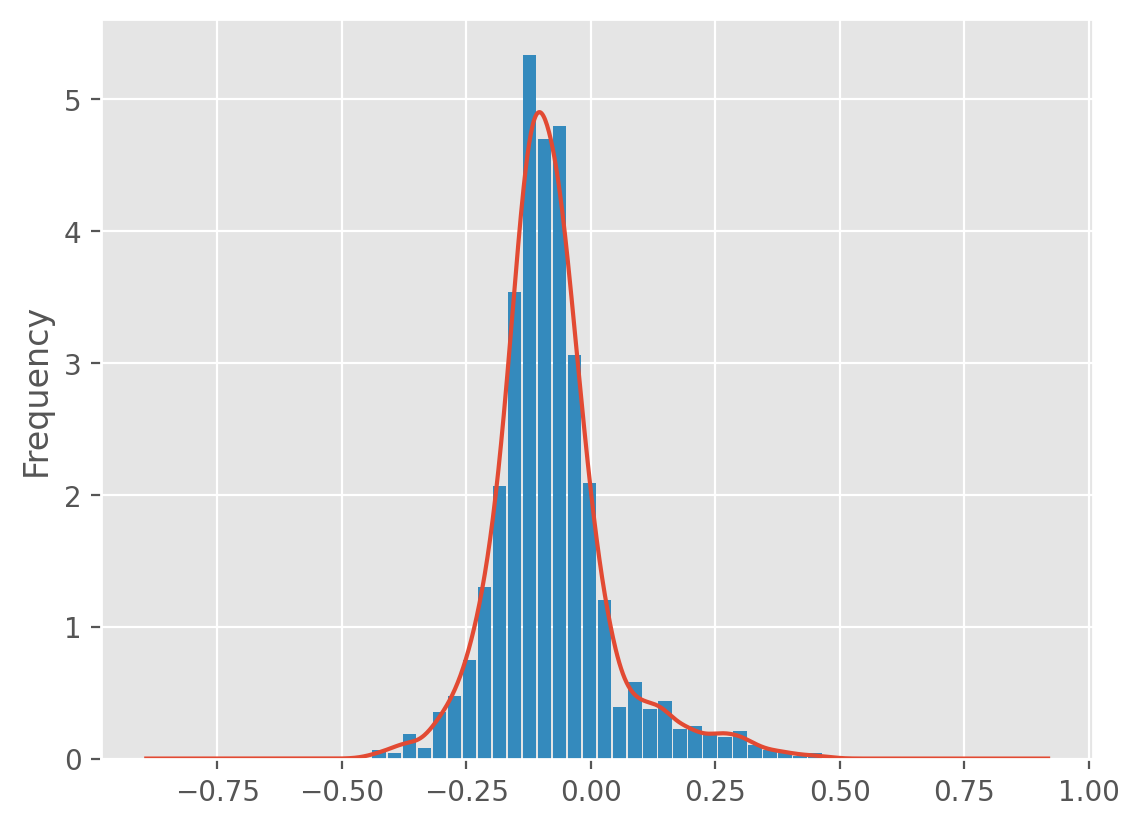

In [5]:
fig, ax1 = plt.subplots()
data["AUCError"].plot.kde(ax=ax1, 
                          grid = True, )
data["AUCError"].plot.hist(ax=ax1,
                           density = True, 
                           bins=30, 
                           rwidth = 0.9 )



## Drug Analysis

### EDA

Finding the worst performing drug in current job

('Drug_988', '2')

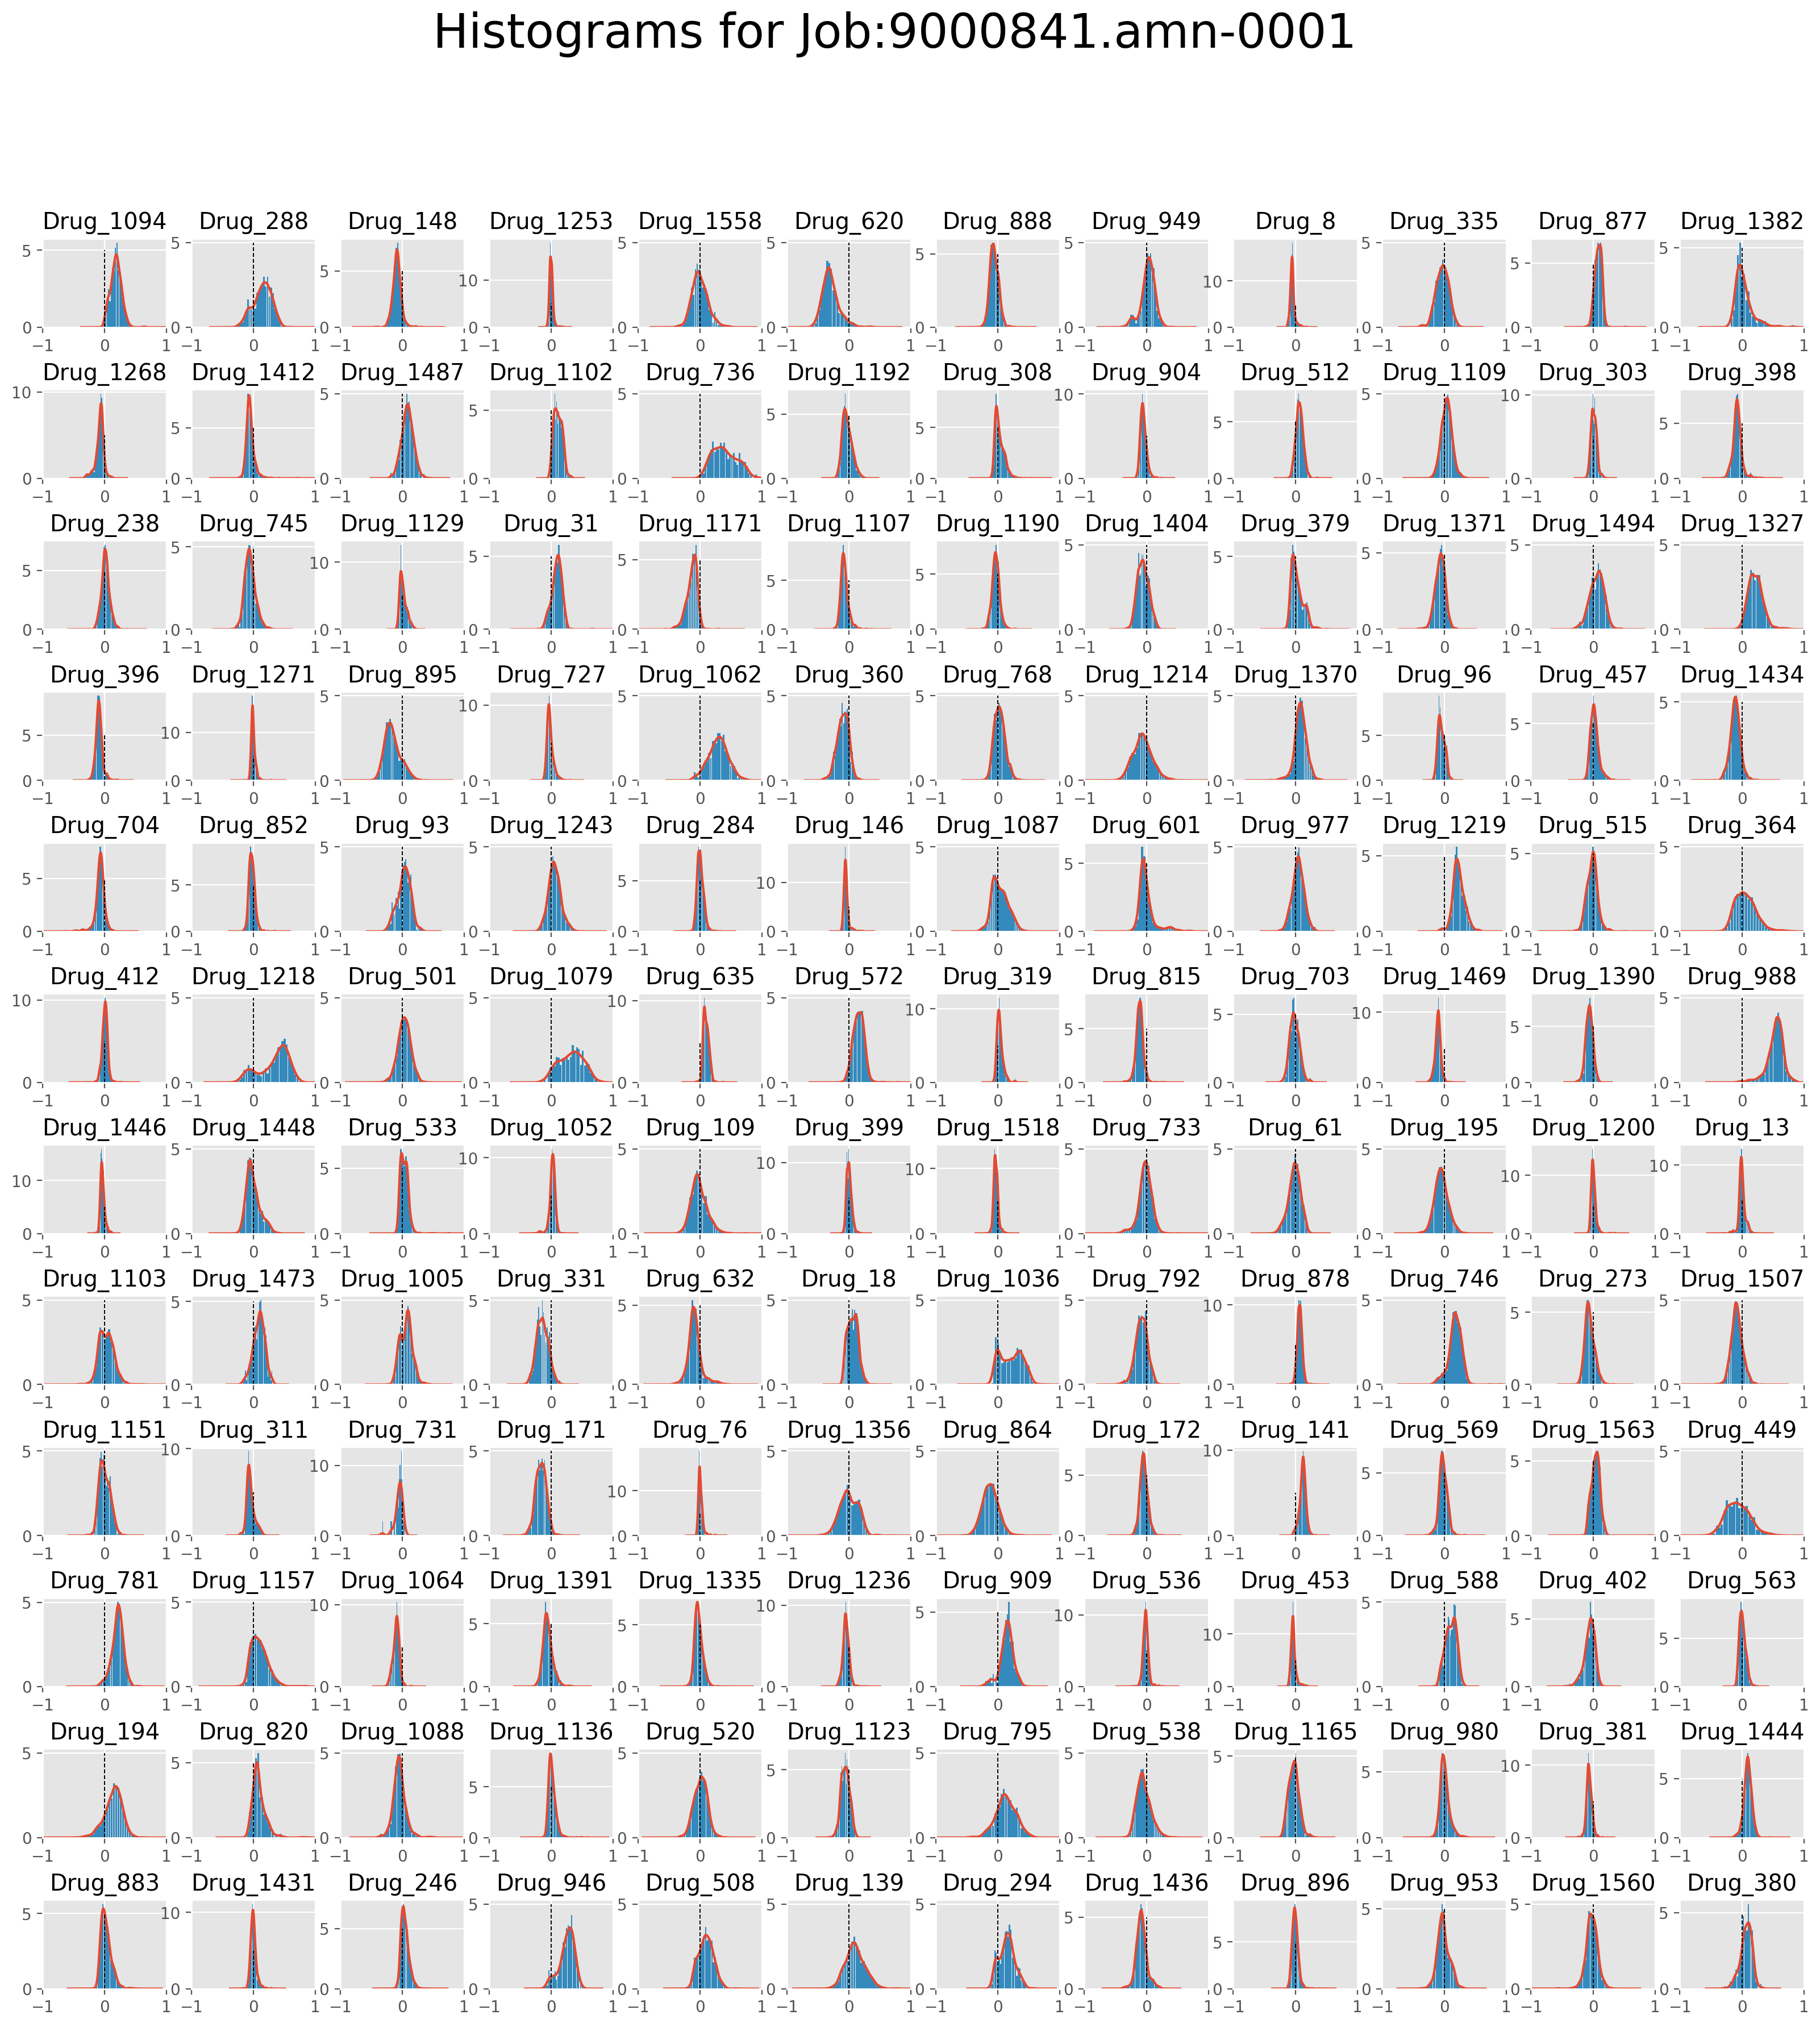

In [6]:
# job = "8996484.amn-0001"
job_loc = os.path.join(path, job)
rmses = {}
vals = []

fig, ax1 = plt.subplots(nrows=12, ncols=12)

fig.subplots_adjust(hspace=0.7)
fig.suptitle(f"Histograms for Job:{job}", fontsize = 30)
fig.set_figwidth(20)
fig.set_figheight(20)

i = 0
j = 0

for subdir, dirs, files in os.walk(job_loc):
    for file in files:
        
        # Importing the file and making a dataframe 
        f = os.path.join(subdir, file)
        df = pd.read_csv(f, sep="\t")
        
        # Getting metadata on file
        fold_num = subdir.split("/")[-1]
        drug = df["Drug1"][0]
        
        # RMSE Calculation
        rmse = mean_squared_error(df["AUC"], df["PredictedAUC"], squared=False)
        vals.append(rmse)
        
        # Collecting all drugs and rmses
        key = (drug, fold_num)
        rmses[(key)] = rmse
        
        
        # Plotting
        df["AUCError"].plot.kde(ax=ax1[i][j], 
                                grid = True)
        df["AUCError"].plot.hist(ax=ax1[i][j],
                                 density = True, 
                                 bins=30, 
                                 rwidth = 0.9 )
        
        ax1[i][j].vlines(x=0, 
                         ymin = 0, 
                         ymax = 5, 
                         linestyles = "dashed", 
                         colors = "black", 
                         linewidth = 0.7)
        
        ax1[i][j].set_title(f"{drug}")
        ax1[i][j].set_ylabel("")
        ax1[i][j].set_xlim(-1, 1)
        # Incrementing 
        i += 1
        if i == 12: 
            j +=1
        i = i % 12


worst = max(rmses, key = rmses.get)
worst

Text(0.5, 0, 'RMSEs of Drugs in Job 9000841.amn-0001')

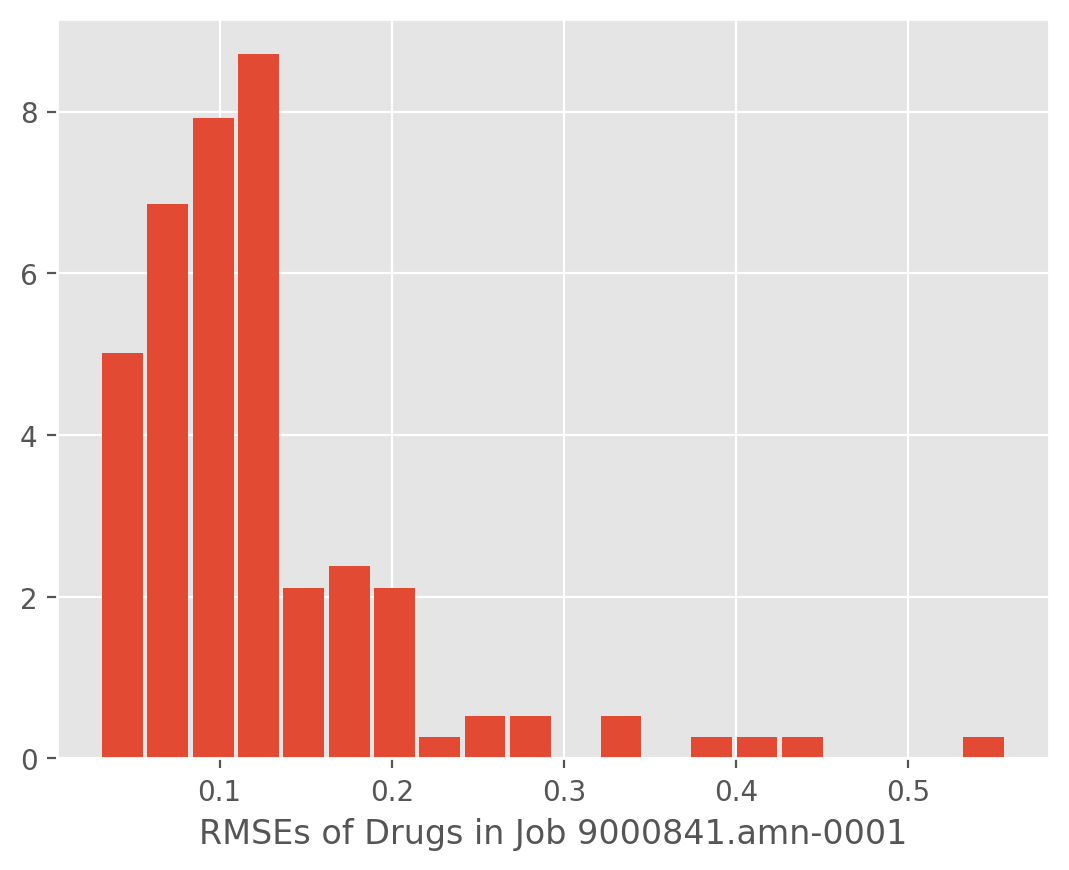

In [7]:
fig, ax1 = plt.subplots()
ax1.hist(x= vals, 
         density = True, 
         bins=20, 
         rwidth = 0.9)
ax1.set_xlabel(f"RMSEs of Drugs in Job {job}")

Checking to see if there is a Drug that always performs bad

In [8]:
worst_of_job = []
worst_drugs = []
jobs = []
rmse_jobs = []
z = 0
d988 = 0
d988_loc = []
all_locations = []

for job in os.listdir(path):
    curr = os.path.join(path, job)
    
    # print(f"----------{job}----------")
    jobs.append(job)
    rmses_curr = {}
    
    for model in os.listdir(curr):
        inner = os.path.join(curr, model)
        
        for subdir, dirs, files in os.walk(inner):
            for file in files:
                        
                # Getting dataframe
                f = os.path.join(subdir, file)
                df = pd.read_csv(f, sep="\t")
                
                # Getting folder locatio and which drug it is 
                fold_num = subdir.split("/")[-1]
                drug = df["Drug1"][0]
                
                # Finding all the locations of Drug988
                if drug == "Drug_988":
                    d988 += 1
                    d988_loc.append((job, fold_num))
                
                # RMSE Calculation
                rmse = mean_squared_error(df["AUC"], df["PredictedAUC"], squared=False)
                
                # Getting drug and rmse for current job
                key = (drug, fold_num)
                rmses_curr[(key)] = rmse
                z += 1
    
    # Find worst performing drug and corseponding rmse
    worst_drug = max(rmses_curr, key = rmses_curr.get)      
    worst_drug_rmse = rmses_curr[worst_drug]
   
    # print(f"{worst_drug[0]}: {worst_drug_rmse}")                  
    
    # Keeping track of worst drugs in each job
    worst_drugs.append(worst_drug[0])
    rmse_jobs.append(worst_drug_rmse)
    all_locations.append(worst_drug[1])
    # worst_of_job[worst_drug] = worst_drug_rmse

# Compile dataframe of all jobs and their worst performing drugs and the rmse 
bad_drugs = pd.DataFrame({"Job":jobs, "Folder":all_locations, "worst_drug":worst_drugs, "RMSE":rmse_jobs})
bad_drugs.sort_values("RMSE", ascending=False)

# Getting the frequency of each drug in the worst drug array
drugs, counts = np.unique(worst_drugs, return_counts=True)

/var/folders/w_/tv9kwn955c59q5gycbr00lzh0000gn/T/ipykernel_33362/1669054811.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(drugs, rotation = 45)


Text(0.5, 0.98, 'Worst Performing Drugs Across All Jobs\n(Worst Drug for Each Job)')

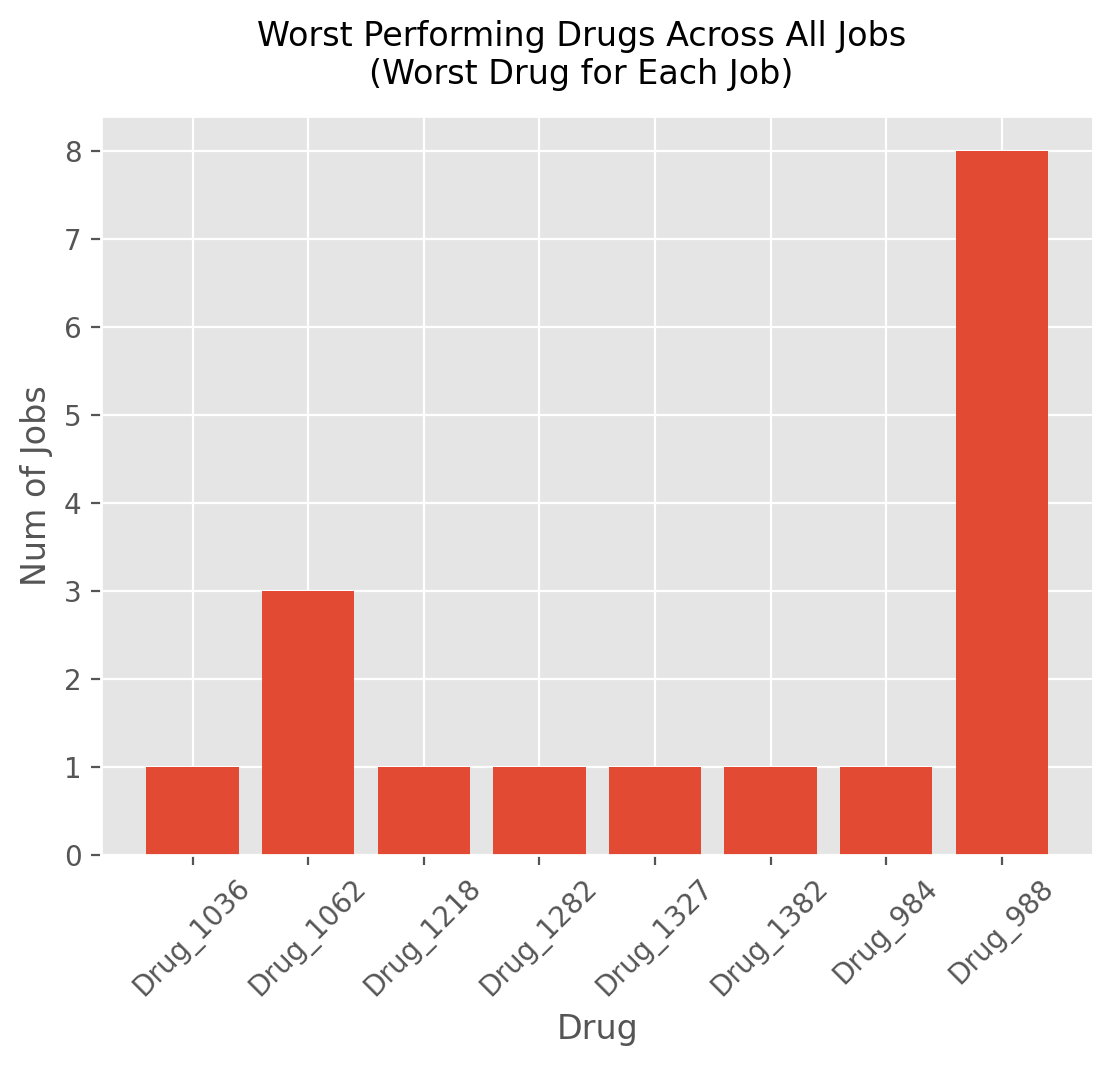

In [9]:
fig, ax = plt.subplots()

ax.bar(drugs, counts)

ax.set_xticklabels(drugs, rotation = 45)
ax.set_ylabel("Num of Jobs")
ax.set_xlabel("Drug")
fig.suptitle("Worst Performing Drugs Across All Jobs\n(Worst Drug for Each Job)")

### Function Definitions

#### Getting All Drugs in 1 Dict

In [10]:
drugs_rmse_curr = {}
job_drugs = []

drugs_perf = {}
for job in os.listdir(path):
    curr = os.path.join(path, job)
    
    print(f"----------{job}----------")
    job_drugs.append(job)
    samples_rmse_curr = {}
    
    for model in tqdm.tqdm(os.listdir(curr)):
        inner = os.path.join(curr, model)
        
        for subdir, dirs, files in os.walk(inner):
            for file in files:
                f = os.path.join(subdir, file)
                df = pd.read_csv(f, sep="\t")
                
                drug = df["Drug1"][0]
                
                if drug not in drugs_perf:
                    drugs_perf[drug] = []
                    drugs_perf[drug].append(df)
                else:
                    drugs_perf[drug].append(df)
                
                    
                    

----------8998707.amn-0001----------


100%|██████████| 12/12 [00:00<00:00, 636.14it/s]


----------8993982.amn-0001----------


100%|██████████| 24/24 [00:00<00:00, 782.05it/s]


----------8991892.amn-0001----------


100%|██████████| 12/12 [00:00<00:00, 777.90it/s]


----------8996461.amn-0001----------


100%|██████████| 480/480 [00:00<00:00, 1095.26it/s]


----------8990757.amn-0001----------


100%|██████████| 24/24 [00:00<00:00, 822.82it/s]


----------8996484.amn-0001----------


100%|██████████| 24/24 [00:00<00:00, 1090.01it/s]


----------8997987.amn-0001----------


100%|██████████| 24/24 [00:00<00:00, 813.31it/s]


----------8999189.amn-0001----------


100%|██████████| 144/144 [00:00<00:00, 946.76it/s]


----------8998722.amn-0001----------


100%|██████████| 144/144 [00:00<00:00, 947.88it/s]


----------8999967.amn-0001----------


100%|██████████| 144/144 [00:00<00:00, 963.58it/s]


----------9000732.amn-0001----------


100%|██████████| 144/144 [00:00<00:00, 973.50it/s]


----------9000896.amn-0001----------


100%|██████████| 144/144 [00:00<00:00, 955.07it/s]


----------8999163.amn-0001----------


100%|██████████| 144/144 [00:00<00:00, 957.45it/s]


----------8998639.amn-0001----------


100%|██████████| 24/24 [00:00<00:00, 876.26it/s]


----------8994056.amn-0001----------


100%|██████████| 216/216 [00:00<00:00, 1027.78it/s]


----------8994012.amn-0001----------


100%|██████████| 36/36 [00:00<00:00, 940.63it/s]


----------9000841.amn-0001----------


100%|██████████| 144/144 [00:00<00:00, 964.17it/s]


In [11]:
drug_dict = {}
for key, value in tqdm.tqdm(drugs_perf.items()):
    drug_dict[key] = pd.concat(value)



100%|██████████| 697/697 [00:00<00:00, 4341.19it/s]


In [12]:
# a = {'hello': 'world'}

with open('drug_data.pickle', 'wb') as handle:
    pickle.dump(drug_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('drug_data.pickle', 'rb') as handle:
    b = pickle.load(handle)


In [13]:
key_list = ["Drug", "RMSE", "n"]
drugs_rmse = {key: [] for key in key_list}


for key, value in drug_dict.items(): 
    drugs_rmse["Drug"].append(key)
    curr_rmse = mean_squared_error(value["AUC"], value["PredictedAUC"], squared=False)
    drugs_rmse["RMSE"].append(curr_rmse)
    drugs_rmse["n"].append(len(value))



In [14]:
all_drugs_df_n = pd.DataFrame(drugs_rmse).sort_values(["n"], ascending=False)
all_drugs_df_rmse = pd.DataFrame(drugs_rmse).sort_values(["RMSE"], ascending=False)
bad_perf_drugs = all_drugs_df_rmse["Drug"][:3]
all_drugs_df_rmse

/var/folders/w_/tv9kwn955c59q5gycbr00lzh0000gn/T/ipykernel_33362/3050632632.py:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  bad_perf_drugs = all_drugs_df_rmse["Drug"][:3]


,Drug,RMSE,n
21,Drug_988,0.445446,20911
581,Drug_736,0.409649,4392
574,Drug_1079,0.401748,5664
557,Drug_1218,0.374331,8808
12,Drug_620,0.274571,6750
...,...,...,...
384,Drug_686,0.025089,193
89,Drug_158,0.024666,577
253,Drug_1287,0.024388,1358
102,Drug_855,0.024208,484


In [15]:
bad_drugs_dfs = {}

for d in bad_perf_drugs:
    bad_drugs_dfs[d] = drug_dict[d]
    
bad_drugs_dfs

{'Drug_988':          AUC      Sample     Drug1  PredictedAUC  AUCError
 0     0.2903  ACH-000001  Drug_988        0.3877   0.09742
 1     0.2636  ACH-000002  Drug_988        0.3540   0.09037
 2     0.2858  ACH-000002  Drug_988        0.3546   0.06882
 3     0.2929  ACH-000002  Drug_988        0.3565   0.06357
 4     0.3114  ACH-000002  Drug_988        0.3711   0.05973
 ...      ...         ...       ...           ...       ...
 1896  0.3578  ACH-001307  Drug_988        0.9452   0.58740
 1897  0.4194  ACH-001307  Drug_988        0.9288   0.50940
 1898  0.3146  ACH-001318  Drug_988        0.9436   0.62900
 1899  0.6505  ACH-001318  Drug_988        0.9672   0.31670
 1900  0.3628  ACH-001321  Drug_988        0.9032   0.54040
 
 [20911 rows x 5 columns],
 'Drug_736':         AUC      Sample     Drug1  PredictedAUC  AUCError
 0    0.4912  ACH-000001  Drug_736        0.9884    0.4972
 1    0.2607  ACH-000002  Drug_736        0.9620    0.7013
 2    0.6061  ACH-000004  Drug_736        0.9789  

Text(0.5, 1.0, 'Distribution of Drug RMSEs')

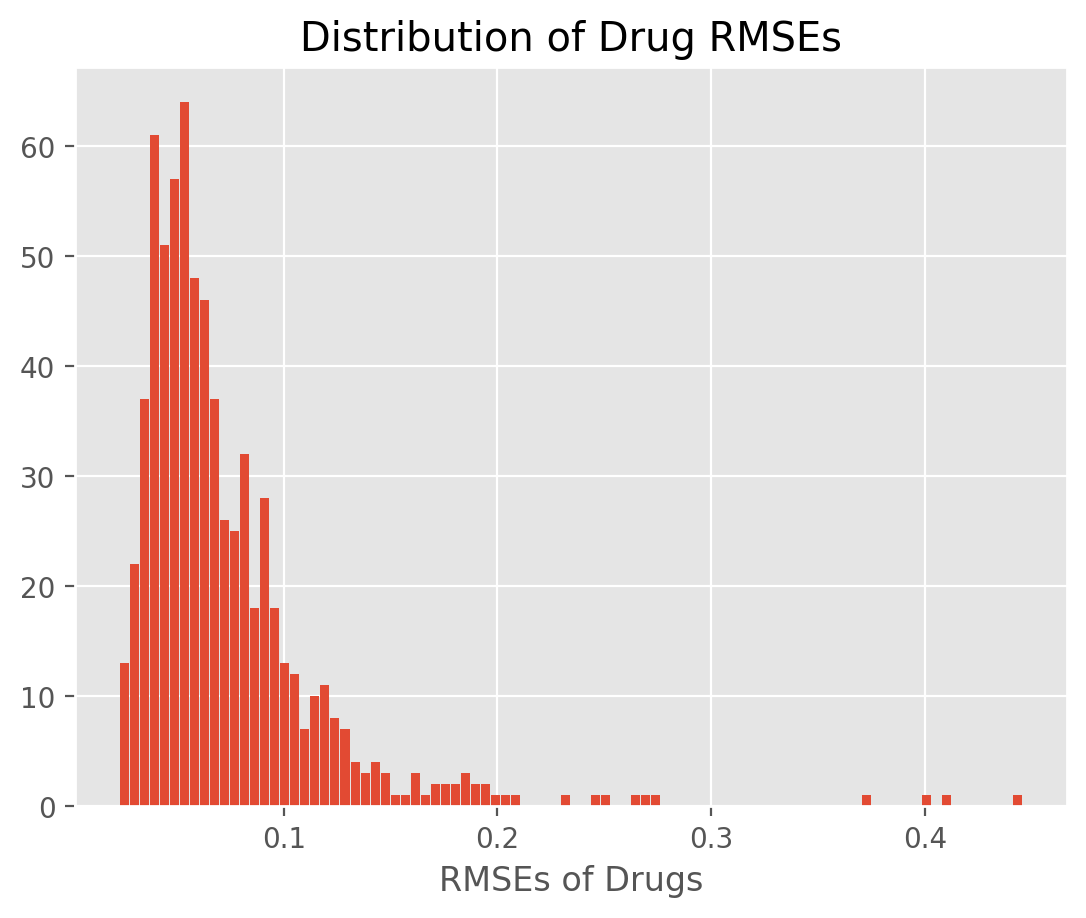

In [16]:
fig, ax1 = plt.subplots()
ax1.hist(x= all_drugs_df_rmse["RMSE"], 
         density = False, 
         bins=90, 
         rwidth = 0.9)
ax1.set_xlabel(f"RMSEs of Drugs")
ax1.set_title("Distribution of Drug RMSEs")

Text(0.5, 0, 'Samples')

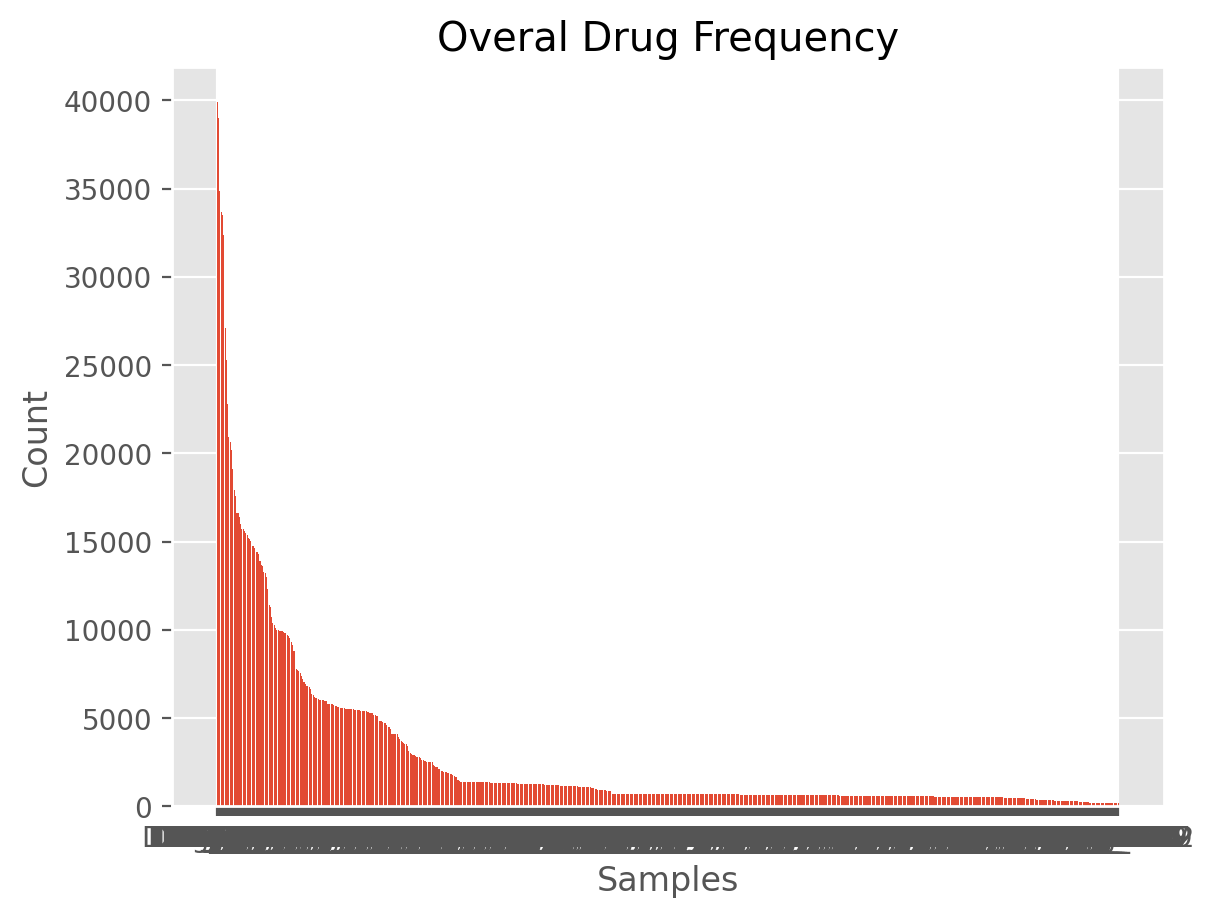

In [17]:
fig, ax = plt.subplots()

ax.bar(all_drugs_df_n["Drug"], all_drugs_df_n["n"])
# ax.plot(all_samples_df["Sample"], all_samples_df["n"], color = "blue")
ax.set_title("Overal Drug Frequency")
ax.set_ylabel("Count")
ax.set_xlabel("Samples")

#### Get All Instances of Certian Drug

In [18]:
def get_all_df_drug(drg, path):
    """Get all the locations of specified drug

    Args:
        drg (string): name of drug 
        path (string): path to all the tsv's

    Returns:
        pandas.Dataframe: a dataframe of all the tsv's about the specified drug
    """
    
    drug_loc = []
    for subdir, dirs, files in os.walk(path):
        for file in files:
            
            # Get file location and make dataframe 
            curr = os.path.join(subdir,file)
            d = pd.read_csv(curr, sep="\t")
            
            # Get metadata on file 
            fold_num = subdir.split("/")[-1]
            drug = d["Drug1"][0]
            job = subdir.split("/")[-2]
            
            # Check if drug in file is same as drg
            if drug == drg:
                drug_loc.append((job, fold_num))
            
    
    # Concatonate all dataframes of all of the tsv's of drg
    dfs = []
    for j,folder in drug_loc:

        file = os.path.join(os.path.join(os.path.join(path, j), folder), "predicted.tsv")

        df = pd.read_csv(file, sep="\t")
        dfs.append(df)

    df = pd.concat(dfs)
    return df

In [19]:
def get_all_drug_dfs(drg, path):
    """Get all the locations of specified drug

    Args:
        drg (string): name of drug 
        path (string): path to all the tsv's

    Returns:
        pandas.Dataframe: a dataframe of all the tsv's about the specified drug
    """
    
    drug_loc = []
    jobs = []
    # for subdir, dirs, files in os.walk(path):
    #     for file in files:
            
    #         # Get file location and make dataframe 
    #         curr = os.path.join(subdir,file)
    #         d = pd.read_csv(curr, sep="\t")
            
    #         # Get metadata on file 
    #         fold_num = subdir.split("/")[-1]
    #         drug = d["Drug1"][0]
    #         job = subdir.split("/")[-2]
    #         print(job)
    #         jobs.append(job)
    #         # Check if drug in file is same as drg
    #         if drug == drg:
    #             drug_loc.append((job, fold_num))
            
    for job in os.listdir(path):
        curr = os.path.join(path, job)
        
        print(f"----------{job}----------")
        jobs.append(job)
        samples_rmse_curr = {}
        
        for model in tqdm.tqdm(os.listdir(curr)):
            inner = os.path.join(curr, model)
            
            for subdir, dirs, files in os.walk(inner):
                for file in files:
                    f = os.path.join(subdir, file)
                    df = pd.read_csv(f, sep="\t")
                    
                    drug = df["Drug1"][0]
                    fold_num = subdir.split("/")[-1]
                    if drg == drug:
                        drug_loc.append((job, fold_num))
    # Concatonate all dataframes of all of the tsv's of drg
    dfs = []
    locs = []
    for j,folder in drug_loc:

        file = os.path.join(os.path.join(os.path.join(path, j), folder), "predicted.tsv")

        df = pd.read_csv(file, sep="\t")
        locs.append((j,folder))
        dfs.append(df)

    return dfs, locs

#### Get Bootstrapped Samples of a Certain Statistic 

In [20]:
def boostraped_rmse(x, B, statsFun): 
    """Create Bootsrtap sample of a statistic

    Args:
        x (num): values you want infrence from 
        B (in): Number of bootstrap samples
        statsFun (fun): metric you want infrence on 
    """

    x = np.array(x)
    
    resampled_stat = []
    
    for b in tqdm.tqdm(range(B)):
        index = np.random.randint(0, len(x), len(x))
        sample = x[index]
        bstatistic = np.sqrt(statsFun(sample**2))
        resampled_stat.append(bstatistic)
        
    return np.array(resampled_stat)
        
test = boostraped_rmse(df["AUCError"], 100000, np.mean)

100%|██████████| 100000/100000 [00:01<00:00, 66271.69it/s]


In [21]:
path = os.path.join(os.path.join(wd, "data"), "TSVs")
get_all_df_drug("Drug_988", path)

,AUC,Sample,Drug1,PredictedAUC,AUCError
0,0.2903,ACH-000001,Drug_988,0.3877,0.09742
1,0.2636,ACH-000002,Drug_988,0.3540,0.09037
2,0.2858,ACH-000002,Drug_988,0.3546,0.06882
3,0.2929,ACH-000002,Drug_988,0.3565,0.06357
4,0.3114,ACH-000002,Drug_988,0.3711,0.05973
...,...,...,...,...,...
1896,0.3578,ACH-001307,Drug_988,0.9452,0.58740
1897,0.4194,ACH-001307,Drug_988,0.9288,0.50940
1898,0.3146,ACH-001318,Drug_988,0.9436,0.62900
1899,0.6505,ACH-001318,Drug_988,0.9672,0.31670


### T-Tests Between Bad Performing Drugs

#### T Tests Between Distribution of Bad Drugs

In [22]:
t_988_736 = st.ttest_ind(bad_drugs_dfs["Drug_988"]["AUCError"], bad_drugs_dfs["Drug_736"]["AUCError"], equal_var = False)
t_988_1079 = st.ttest_ind(bad_drugs_dfs["Drug_988"]["AUCError"], bad_drugs_dfs["Drug_1079"]["AUCError"], equal_var = False)
t_736_1079 = st.ttest_ind(bad_drugs_dfs["Drug_736"]["AUCError"], bad_drugs_dfs["Drug_1079"]["AUCError"], equal_var = False)


print(f"Drug_988 vs. Drug_736: {t_988_736}") ############# WHY IS IT NOT SIGNIFICANT HERE BUT IS AFTER BOOTSTRAPPING???????????
print(f"Drug_988 vs. Drug_1079: {t_988_1079}")
print(f"Drug_736 vs. Drug_1079: {t_736_1079}")


Drug_988 vs. Drug_736: Ttest_indResult(statistic=-0.015374926606377383, pvalue=0.9877334683196239)
Drug_988 vs. Drug_1079: Ttest_indResult(statistic=3.0309638935077223, pvalue=0.0024434477960989976)
Drug_736 vs. Drug_1079: Ttest_indResult(statistic=2.4156412597953927, pvalue=0.015726307631592586)


#### T Tests Between boostrapped Versions of Bad Drugs

In [23]:
b_988 = boostraped_rmse(bad_drugs_dfs["Drug_988"]["AUCError"], 100000, np.mean)
b_736 = boostraped_rmse(bad_drugs_dfs["Drug_736"]["AUCError"], 100000, np.mean)
b_1079 = boostraped_rmse(bad_drugs_dfs["Drug_1079"]["AUCError"], 100000, np.mean)

100%|██████████| 100000/100000 [00:08<00:00, 11135.87it/s]


In [24]:
t_b988_b736 = st.ttest_ind(b_988, b_736, equal_var = False)
t_b988_b1079 = st.ttest_ind(b_988, b_1079, equal_var = False)
t_b736_b1079 = st.ttest_ind(b_736, b_1079, equal_var = False)


print(f"Boot_Drug_988 vs. Boot_Drug_736: {t_b988_b736}")
print(f"Boot_Drug_988 vs. Boot_Drug_1079: {t_b988_b1079}")
print(f"Boot_Drug_736 vs. Boot_Drug_1079: {t_b736_b1079}")

Boot_Drug_988 vs. Boot_Drug_736: Ttest_indResult(statistic=3387.8064744727717, pvalue=0.0)
Boot_Drug_988 vs. Boot_Drug_1079: Ttest_indResult(statistic=4656.284823179602, pvalue=0.0)
Boot_Drug_736 vs. Boot_Drug_1079: Ttest_indResult(statistic=616.3248644670438, pvalue=0.0)


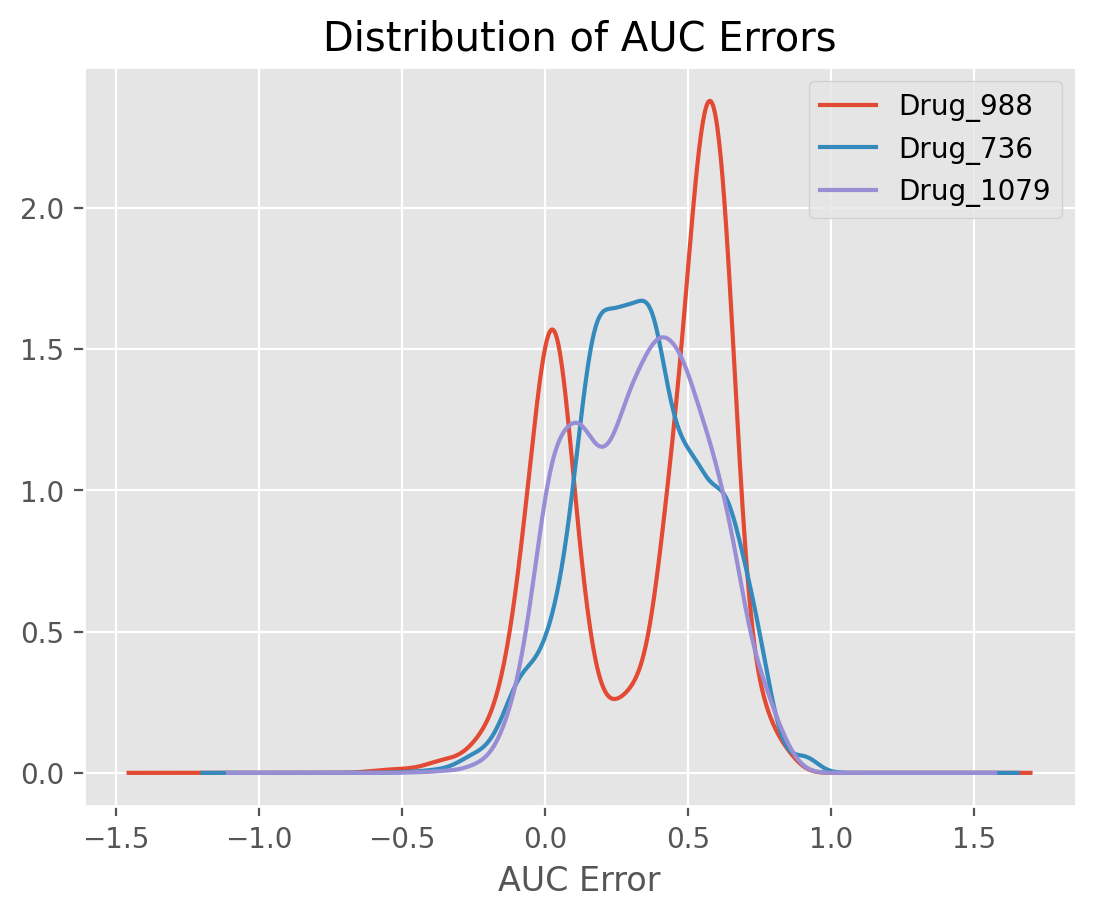

In [25]:
fig, ax1 = plt.subplots()
bad_drugs_dfs["Drug_988"]["AUCError"].plot.kde(ax=ax1, 
                        grid = True, )
# bad_drugs_dfs["Drug_988"]["AUCError"].plot.hist(ax=ax1,
#                          density = True, 
#                          bins=30, 
#                          rwidth = 0.9 )

bad_drugs_dfs["Drug_736"]["AUCError"].plot.kde(ax=ax1, 
                        grid = True, )
# bad_drugs_dfs["Drug_736"]["AUCError"].plot.hist(ax=ax1,
#                          density = True, 
#                          bins=30, 
#                          rwidth = 0.9 )

bad_drugs_dfs["Drug_1079"]["AUCError"].plot.kde(ax=ax1, 
                        grid = True,)
# bad_drugs_dfs["Drug_1079"]["AUCError"].plot.hist(ax=ax1,
#                          density = True, 
#                          bins=30, 
#                          rwidth = 0.9 )

ax1.set_title(f"Distribution of AUC Errors")
ax1.set_ylabel("")
ax1.set_xlabel("AUC Error")
plt.legend(["Drug_988", "Drug_736", "Drug_1079"])

(0.40172801135907166, 0.4017608170661642)

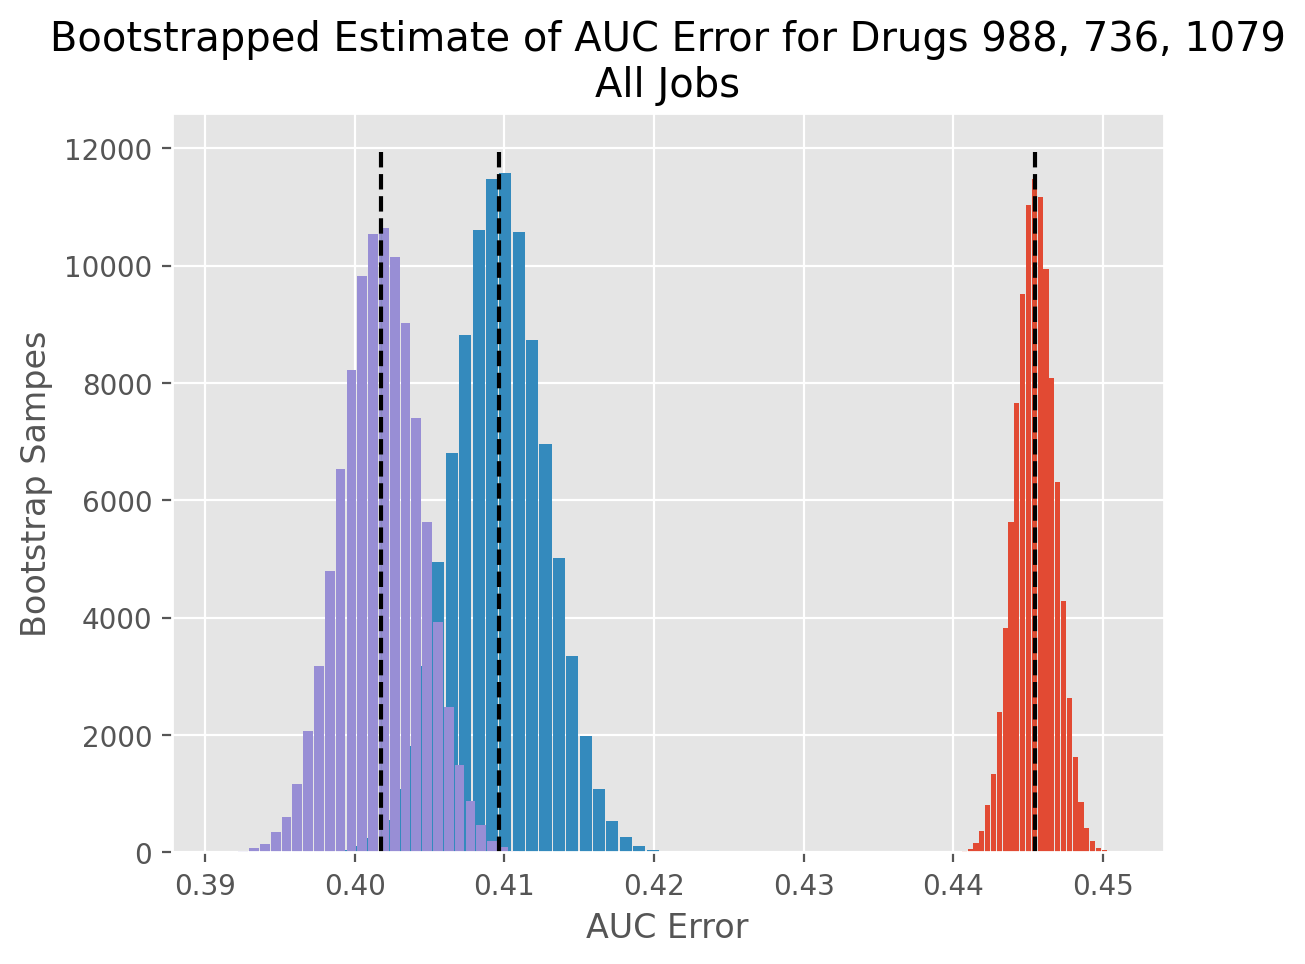

In [26]:
fig, ax = plt.subplots()
confint = st.t.interval(confidence = 0.95, 
                        df = len(b_988)-1, 
                        loc = np.mean(b_988), 
                        scale = st.sem(b_988) )

heights, bins, patches = ax.hist(b_988, bins=30, rwidth=0.9)
ax.fill_betweenx([0, heights.max()],confint[0], confint[1], alpha = 0.1, color = "g")
ax.vlines(x = np.mean(b_988), 
          ymin = 0, 
          ymax=12000, 
          colors="black", 
          linestyles="dashed")
# ax.text(x = min(boot_all_988), y = 12000, s = confint, size = 8)
# ax.set_title(f"Bootstrapped Estimate of AUC Error for Drug 988\nAll Jobs")
# ax.set_ylabel("Bootstrap Sampes")
# ax.set_xlabel("AUC Error")

confint = st.t.interval(confidence = 0.95, 
                        df = len(b_736)-1, 
                        loc = np.mean(b_736), 
                        scale = st.sem(b_736) )

heights, bins, patches = ax.hist(b_736, bins=30, rwidth=0.9)
ax.fill_betweenx([0, heights.max()],confint[0], confint[1], alpha = 0.1, color = "g")
ax.vlines(x = np.mean(b_736), 
          ymin = 0, 
          ymax=12000, 
          colors="black", 
          linestyles="dashed")
# ax.text(x = min(boot_all_988), y = 12000, s = confint, size = 8)
# ax.set_title(f"Bootstrapped Estimate of AUC Error for Drug 988\nAll Jobs")
# ax.set_ylabel("Bootstrap Sampes")
# ax.set_xlabel("AUC Error")

confint = st.t.interval(confidence = 0.95, 
                        df = len(b_1079)-1, 
                        loc = np.mean(b_1079), 
                        scale = st.sem(b_1079) )

heights, bins, patches = ax.hist(b_1079, bins=30, rwidth=0.9)
ax.fill_betweenx([0, heights.max()],confint[0], confint[1], alpha = 0.1, color = "g")
ax.vlines(x = np.mean(b_1079), 
          ymin = 0, 
          ymax=12000, 
          colors="black", 
          linestyles="dashed")
# ax.text(x = min(boot_all_988), y = 12000, s = confint, size = 8)
ax.set_title(f"Bootstrapped Estimate of AUC Error for Drugs 988, 736, 1079\nAll Jobs")
ax.set_ylabel("Bootstrap Sampes")
ax.set_xlabel("AUC Error")
confint

### Drug 988 Investigation

#### Drug 988 In Specific Job

In [27]:
path = os.path.join(os.path.join(wd, "data"), "TSVs")
job_988 = "9000841.amn-0001"
num = "2"
file = os.path.join(os.path.join(os.path.join(path, job_988), num), "predicted.tsv")
file

'/Users/jakegwinn/Documents/argonne/data/TSVs/9000841.amn-0001/2/predicted.tsv'

In [28]:
df988 = pd.read_csv(file, sep="\t")
df988

,AUC,Sample,Drug1,PredictedAUC,AUCError
0,0.2903,ACH-000001,Drug_988,0.9648,0.6745
1,0.2636,ACH-000002,Drug_988,0.9526,0.6890
2,0.2858,ACH-000002,Drug_988,0.9584,0.6726
3,0.2929,ACH-000002,Drug_988,0.9618,0.6689
4,0.3114,ACH-000002,Drug_988,0.9412,0.6298
...,...,...,...,...,...
1896,0.3578,ACH-001307,Drug_988,0.9452,0.5874
1897,0.4194,ACH-001307,Drug_988,0.9288,0.5094
1898,0.3146,ACH-001318,Drug_988,0.9436,0.6290
1899,0.6505,ACH-001318,Drug_988,0.9672,0.3167


Text(0.5, 0, 'AUC Error')

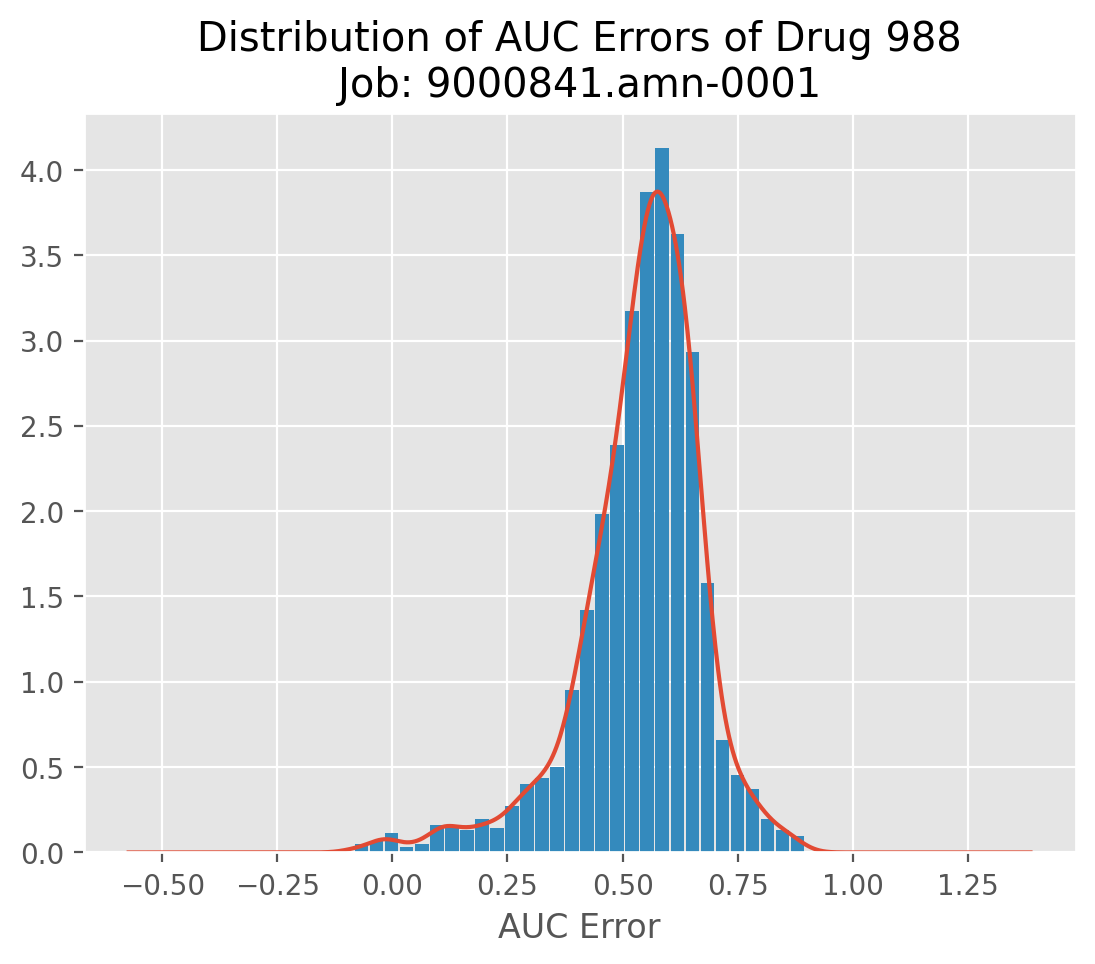

In [29]:
fig, ax1 = plt.subplots()
df988["AUCError"].plot.kde(ax=ax1, 
                        grid = True, )
df988["AUCError"].plot.hist(ax=ax1,
                         density = True, 
                         bins=30, 
                         rwidth = 0.9 )

ax1.set_title(f"Distribution of AUC Errors of Drug 988\nJob: {job}")
ax1.set_ylabel("")
ax1.set_xlabel("AUC Error")

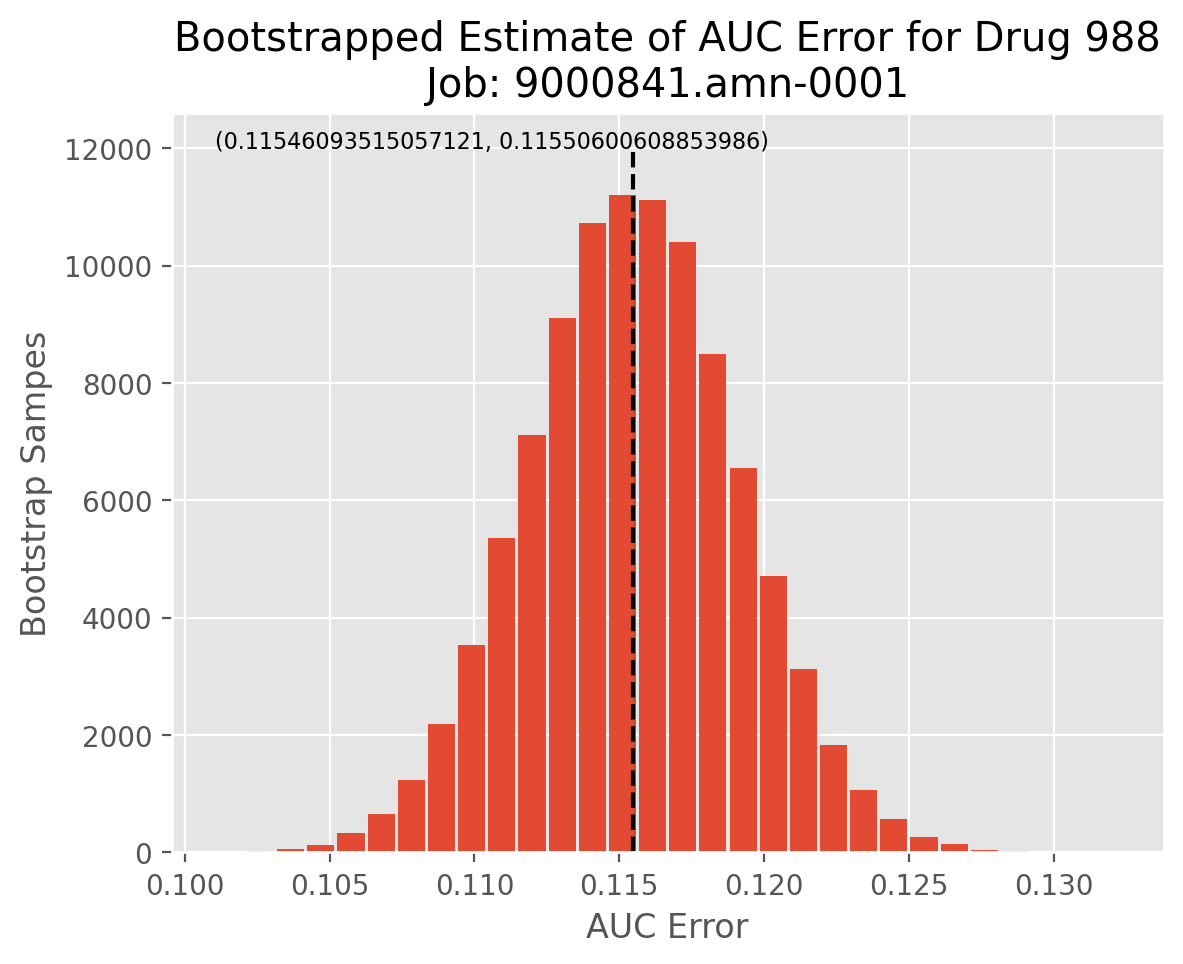

In [30]:
fig, ax = plt.subplots()
confint = st.t.interval(confidence = 0.95, 
                        df = len(test)-1, 
                        loc = np.mean(test), 
                        scale = st.sem(test) )

heights, bins, patches = ax.hist(test, bins=30, rwidth=0.9)
ax.vlines(x = np.mean(test), 
          ymin = 0, 
          ymax=12000, 
          colors="black", 
          linestyles="dashed")

ax.set_title(f"Bootstrapped Estimate of AUC Error for Drug 988\nJob: {job_988}")
ax.set_ylabel("Bootstrap Sampes")
ax.set_xlabel("AUC Error")
ax.text(x = min(test), y = 12000, s = confint, size = 8)
ax.fill_betweenx([0, heights.max()],confint[0], confint[1], alpha = 0.1, color = "g")

#### Looking at all Drug 988 Instances 

In [31]:
df_988 = get_all_df_drug("Drug_988", path=path)
rmse = mean_squared_error(df_988["AUC"], df_988["PredictedAUC"], squared=False)
rmse

0.44544628651774065

In [32]:
samples, count = np.unique(df_988["Sample"], return_counts=True)

samples_df = pd.DataFrame({"Sample":samples, "Count":count})

samples_df = samples_df.sort_values("Count", ascending=False)

samples_df.head(20)
# d_988 = pd.merge(df_988_worst_tumor, samples_df)
# d_988.sort_values(["Count", "AUCError"], ascending=False, key=np.abs)

,Sample,Count
472,ACH-000651,253
147,ACH-000219,253
252,ACH-000364,242
495,ACH-000681,231
749,ACH-000997,220
420,ACH-000580,220
691,ACH-000927,88
151,ACH-000223,88
69,ACH-000106,88
548,ACH-000750,77


Text(0.5, 0, 'AUC Error')

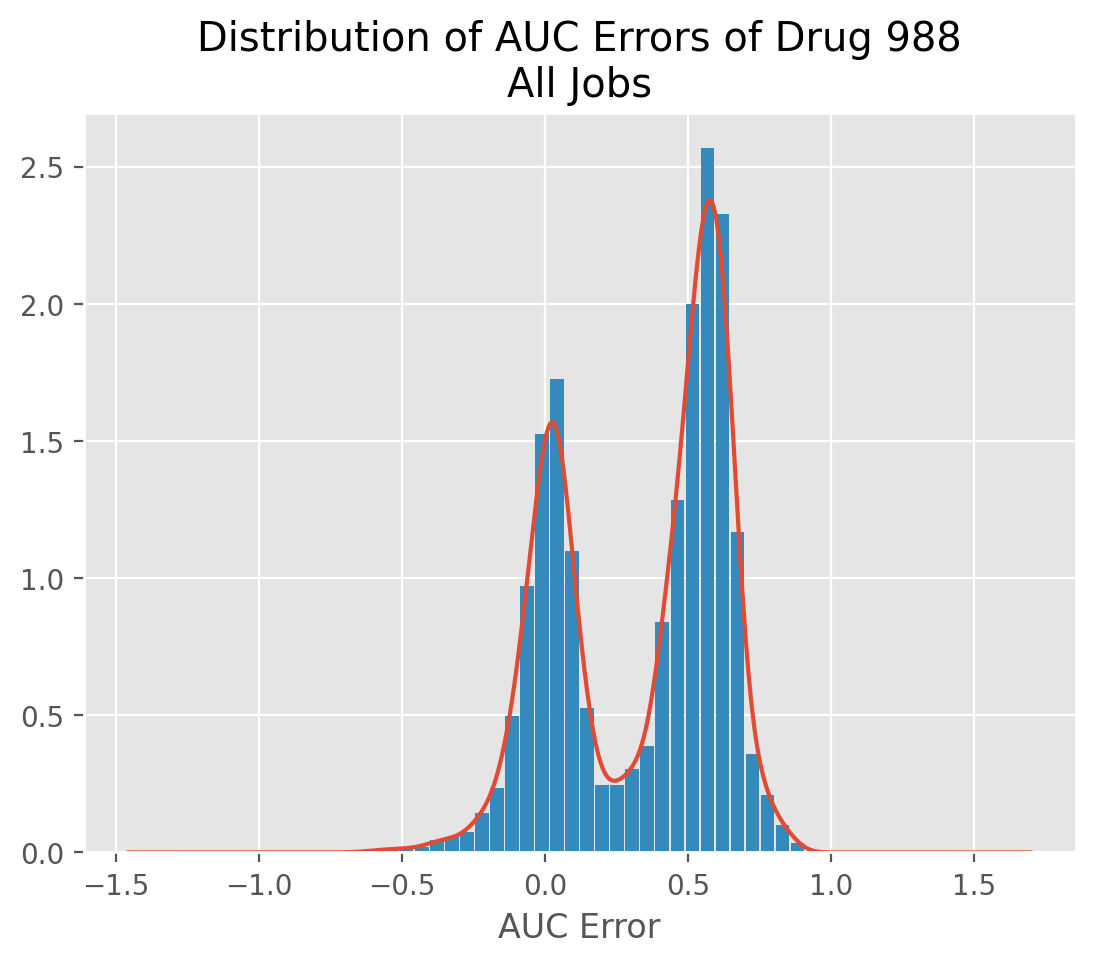

In [33]:
fig, ax1 = plt.subplots()
df_988["AUCError"].plot.kde(ax=ax1, 
                        grid = True, )
df_988["AUCError"].plot.hist(ax=ax1,
                         density = True, 
                         bins=30, 
                         rwidth = 0.9)

ax1.set_title(f"Distribution of AUC Errors of Drug 988\nAll Jobs")
ax1.set_ylabel("")
ax1.set_xlabel("AUC Error")

In [34]:
dfs_988, jobs_988 = get_all_drug_dfs(drg="Drug_988", path=path)
# print(dfs_988)
# print(jobs_988)

----------8998707.amn-0001----------


100%|██████████| 12/12 [00:00<00:00, 794.55it/s]


----------8993982.amn-0001----------


100%|██████████| 24/24 [00:00<00:00, 775.57it/s]


----------8991892.amn-0001----------


100%|██████████| 12/12 [00:00<00:00, 738.68it/s]


----------8996461.amn-0001----------


100%|██████████| 480/480 [00:00<00:00, 1087.23it/s]


----------8990757.amn-0001----------


100%|██████████| 24/24 [00:00<00:00, 832.77it/s]


----------8996484.amn-0001----------


100%|██████████| 24/24 [00:00<00:00, 1097.60it/s]


----------8997987.amn-0001----------


100%|██████████| 24/24 [00:00<00:00, 827.65it/s]


----------8999189.amn-0001----------


100%|██████████| 144/144 [00:00<00:00, 958.87it/s]


----------8998722.amn-0001----------


100%|██████████| 144/144 [00:00<00:00, 947.87it/s]


----------8999967.amn-0001----------


100%|██████████| 144/144 [00:00<00:00, 849.22it/s]


----------9000732.amn-0001----------


100%|██████████| 144/144 [00:00<00:00, 672.42it/s]


----------9000896.amn-0001----------


100%|██████████| 144/144 [00:00<00:00, 939.34it/s]


----------8999163.amn-0001----------


100%|██████████| 144/144 [00:00<00:00, 935.24it/s]


----------8998639.amn-0001----------


100%|██████████| 24/24 [00:00<00:00, 822.18it/s]


----------8994056.amn-0001----------


100%|██████████| 216/216 [00:00<00:00, 988.17it/s] 


----------8994012.amn-0001----------


100%|██████████| 36/36 [00:00<00:00, 882.68it/s]


----------9000841.amn-0001----------


100%|██████████| 144/144 [00:00<00:00, 907.28it/s]


In [35]:
# for i, d in enumerate(dfs_988):
#     fig, ax1 = plt.subplots()
#     d["AUCError"].plot.kde(ax=ax1, 
#                             grid = True, )
#     d["AUCError"].plot.hist(ax=ax1,
#                             density = True, 
#                             bins=30, 
#                             rwidth = 0.9 )

#     ax1.set_title(f"Distribution of AUC Errors of Drug 988\nJob: {jobs_988[i]}")
#     ax1.set_ylabel("")
#     ax1.set_xlabel("AUC Error")

In [36]:
key_list = ["Job", "Folder", "Mean"]
jobs_perf_988 = {key: [] for key in key_list}



for i, d in enumerate(dfs_988):
    jobs_perf_988["Job"].append(jobs_988[i][0])
    jobs_perf_988["Folder"].append(jobs_988[i][1])
    jobs_perf_988["Mean"].append(np.mean(d["AUCError"]))

jobs_perf_988_df = pd.DataFrame(jobs_perf_988)
jobs_perf_988_df.sort_values("Mean")

good_perf_jobs_988 = jobs_perf_988_df.sort_values("Mean")[:4]
bad_perf_jobs_988 = jobs_perf_988_df.sort_values("Mean")[4:]
bad_perf_jobs_988

,Job,Folder,Mean
5,8998722.amn-0001,2,0.525305
9,8999163.amn-0001,2,0.530654
7,9000732.amn-0001,2,0.531707
4,8999189.amn-0001,2,0.535721
8,9000896.amn-0001,2,0.538218
10,9000841.amn-0001,2,0.540458
6,8999967.amn-0001,2,0.544090


/var/folders/w_/tv9kwn955c59q5gycbr00lzh0000gn/T/ipykernel_33362/1736267308.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(jobs_perf_988_df["Job"], rotation = 90)


Text(0, 0.5, 'Mean AUC Error')

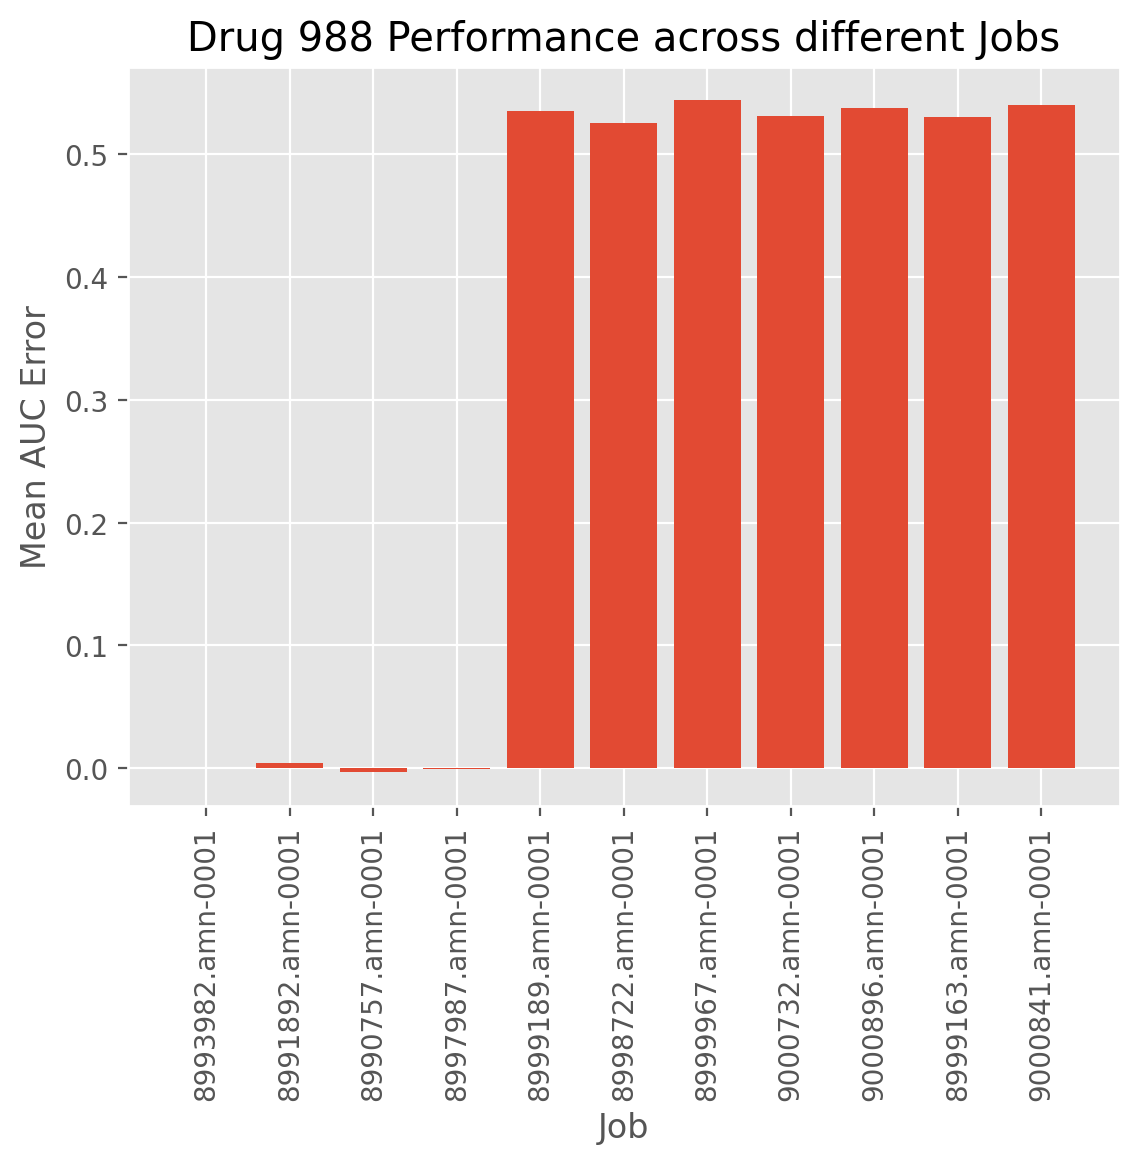

In [37]:
# print(jobs_perf_988_df)
fig, ax = plt.subplots()

ax.bar(jobs_perf_988_df["Job"], jobs_perf_988_df["Mean"])

ax.set_xticklabels(jobs_perf_988_df["Job"], rotation = 90)
ax.set_title("Drug 988 Performance across different Jobs")
ax.set_xlabel("Job")
ax.set_ylabel("Mean AUC Error")


#### Figuring out Why Drug 988 is Bimodal

##### Good Performing Jobs

In [38]:
path = os.path.join(os.path.join(wd, "data"), "TSVs")

job_samples_988 = {}

good_jobs_988 = []
for i, row in good_perf_jobs_988.iterrows():
    job = row["Job"]
    # print(job)
    fold = row["Folder"]
    # print(fold)
    file = os.path.join(os.path.join(os.path.join(path, job), fold), "predicted.tsv")
    
    df = pd.read_csv(file, sep="\t")
    good_jobs_988.append(df)
    # print(df)
    samps = df["Sample"].unique()
    
    job_samples_988[job] = set(samps)
    
samps = []
for k, v in job_samples_988.items():
    
    # print(job_samples_988[k])
    samps.append(job_samples_988[k])
    print(len(job_samples_988[k]))

good_jobs_988_df = pd.concat(good_jobs_988)

good_samps_988 = set.intersection(*samps)
print(len(good_samps_988))
good_jobs_988_df

760
760
760
760
760


,AUC,Sample,Drug1,PredictedAUC,AUCError
0,0.2903,ACH-000001,Drug_988,0.3986,0.108300
1,0.2636,ACH-000002,Drug_988,0.3263,0.062690
2,0.2858,ACH-000002,Drug_988,0.3347,0.048940
3,0.2929,ACH-000002,Drug_988,0.2987,0.005814
4,0.3114,ACH-000002,Drug_988,0.2774,-0.034010
...,...,...,...,...,...
1896,0.3578,ACH-001307,Drug_988,0.3440,-0.013850
1897,0.4194,ACH-001307,Drug_988,0.3757,-0.043740
1898,0.3146,ACH-001318,Drug_988,0.3986,0.084030
1899,0.6505,ACH-001318,Drug_988,0.4177,-0.232800


##### Bad Performing Jobs

In [39]:
path = os.path.join(os.path.join(wd, "data"), "TSVs")

job_samples_988 = {}

bad_jobs_988 = []
for i, row in bad_perf_jobs_988.iterrows():
    job = row["Job"]
    # print(job)
    fold = row["Folder"]
    # print(fold)
    file = os.path.join(os.path.join(os.path.join(path, job), fold), "predicted.tsv")
    
    df = pd.read_csv(file, sep="\t")
    bad_jobs_988.append(df)
    # print(df)
    samps = df["Sample"].unique()
    
    job_samples_988[job] = set(samps)
    
samps = []
for k, v in job_samples_988.items():
    
    # print(job_samples_988[k])
    samps.append(job_samples_988[k])
    # print(len(job_samples_988[k]))
bad_jobs_988_df = pd.concat(bad_jobs_988)
bad_samps_988 = set.intersection(*samps)
print(len(good_samps_988.symmetric_difference(bad_samps_988)))
bad_jobs_988_df

0


,AUC,Sample,Drug1,PredictedAUC,AUCError
0,0.2903,ACH-000001,Drug_988,0.9545,0.6642
1,0.2636,ACH-000002,Drug_988,0.9404,0.6768
2,0.2858,ACH-000002,Drug_988,0.9187,0.6329
3,0.2929,ACH-000002,Drug_988,0.9428,0.6499
4,0.3114,ACH-000002,Drug_988,0.9060,0.5946
...,...,...,...,...,...
1896,0.3578,ACH-001307,Drug_988,0.9292,0.5714
1897,0.4194,ACH-001307,Drug_988,0.8989,0.4795
1898,0.3146,ACH-001318,Drug_988,0.9071,0.5925
1899,0.6505,ACH-001318,Drug_988,0.9477,0.2972


So both good and bad jobs use same samples. 

##### T Test

In [40]:
st.ttest_ind(good_jobs_988_df["AUCError"], bad_jobs_988_df["AUCError"], equal_var = False)

Ttest_indResult(statistic=-304.5457093632798, pvalue=0.0)

#### Bootstrapping


In [41]:
boot_all_988 = boostraped_rmse(df_988["AUCError"], 100000, np.mean)

100%|██████████| 100000/100000 [00:32<00:00, 3033.42it/s]


(0.4454370247594331, 0.445453754523865)

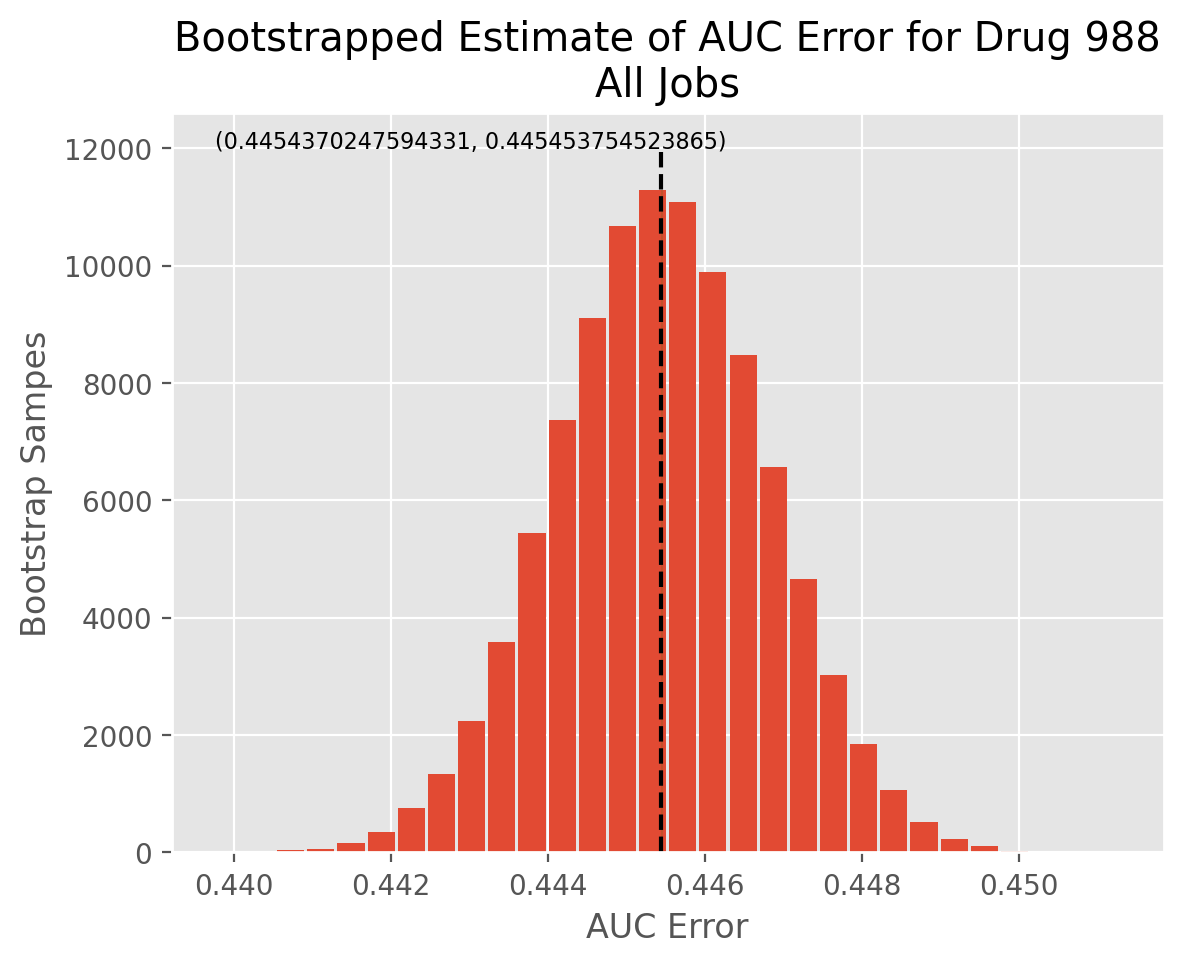

In [42]:
fig, ax = plt.subplots()
confint = st.t.interval(confidence = 0.95, 
                        df = len(boot_all_988)-1, 
                        loc = np.mean(boot_all_988), 
                        scale = st.sem(boot_all_988) )

heights, bins, patches = ax.hist(boot_all_988, bins=30, rwidth=0.9)
ax.fill_betweenx([0, heights.max()],confint[0], confint[1], alpha = 0.1, color = "g")
ax.vlines(x = np.mean(boot_all_988), 
          ymin = 0, 
          ymax=12000, 
          colors="black", 
          linestyles="dashed")
ax.text(x = min(boot_all_988), y = 12000, s = confint, size = 8)
ax.set_title(f"Bootstrapped Estimate of AUC Error for Drug 988\nAll Jobs")
ax.set_ylabel("Bootstrap Sampes")
ax.set_xlabel("AUC Error")
confint

### Drug 1062 Investigation 

In [43]:
path = os.path.join(os.path.join(wd, "data"), "TSVs")
df1062 = get_all_df_drug("Drug_1062", path=path)
df1062

,AUC,Sample,Drug1,PredictedAUC,AUCError
0,0.6374,ACH-000001,Drug_1062,0.6426,0.005157
1,0.5095,ACH-000002,Drug_1062,0.5622,0.052730
2,0.4092,ACH-000004,Drug_1062,0.4547,0.045550
3,0.5791,ACH-000006,Drug_1062,0.5208,-0.058290
4,0.5159,ACH-000007,Drug_1062,0.7144,0.198500
...,...,...,...,...,...
572,0.4697,ACH-001106,Drug_1062,0.7892,0.319500
573,0.2023,ACH-001190,Drug_1062,0.8907,0.688400
574,0.4623,ACH-001306,Drug_1062,0.8831,0.420800
575,0.3054,ACH-001307,Drug_1062,0.8397,0.534300


In [44]:
np.mean(df1062["AUCError"])

0.18196998021285649

Text(0.5, 0, 'AUC Error')

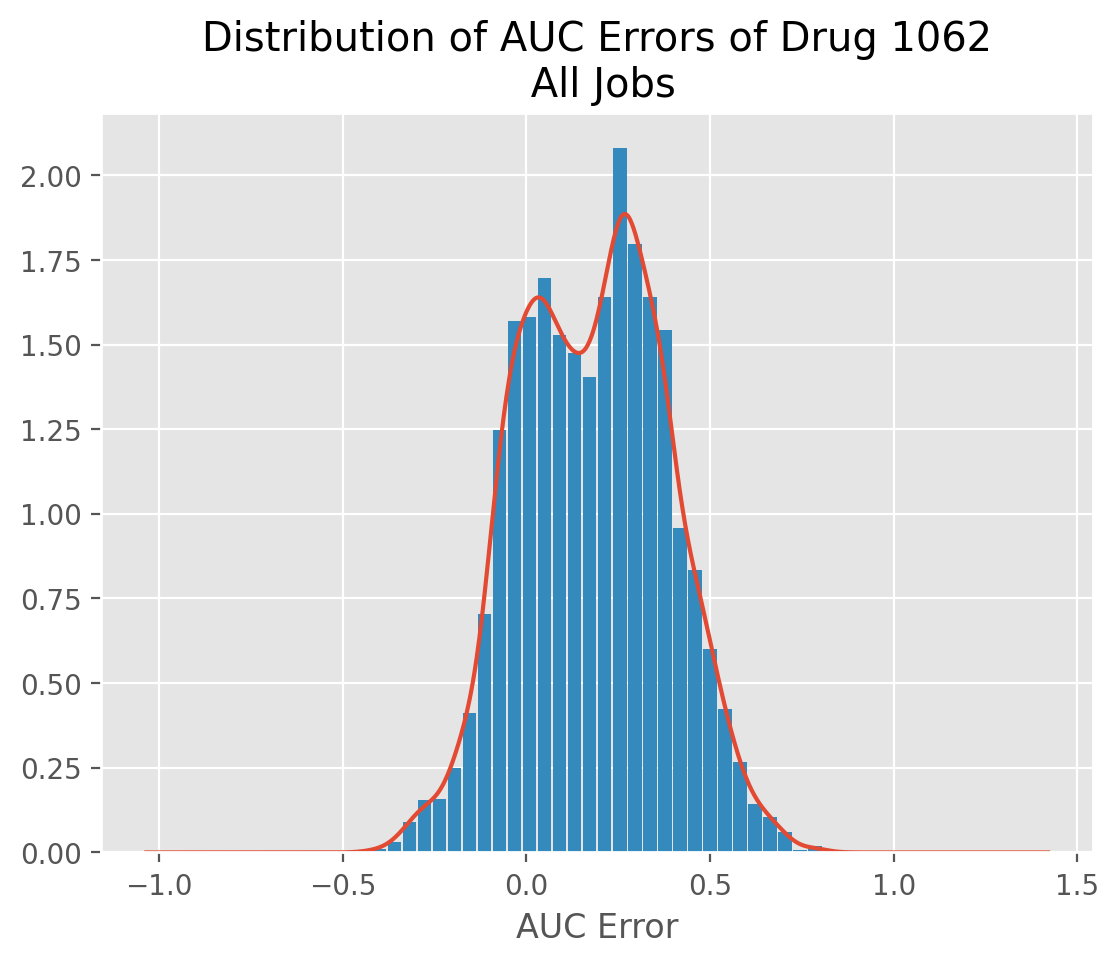

In [45]:
fig, ax1 = plt.subplots()
df1062["AUCError"].plot.kde(ax=ax1, 
                            grid = True, )
df1062["AUCError"].plot.hist(ax=ax1,
                             density = True, 
                             bins=30, rwidth = 0.9 )

ax1.set_title(f"Distribution of AUC Errors of Drug 1062\n All Jobs")
ax1.set_ylabel("")
ax1.set_xlabel("AUC Error")

In [46]:
boot_all_1062 = boostraped_rmse(df1062["AUCError"], 100000, np.mean)
print(boot_all_1062)

100%|██████████| 100000/100000 [00:07<00:00, 12728.85it/s]

[0.26936419 0.26868305 0.26803325 ... 0.27181785 0.26607054 0.26953597]


(0.26981179846056585, 0.26983733033199503)

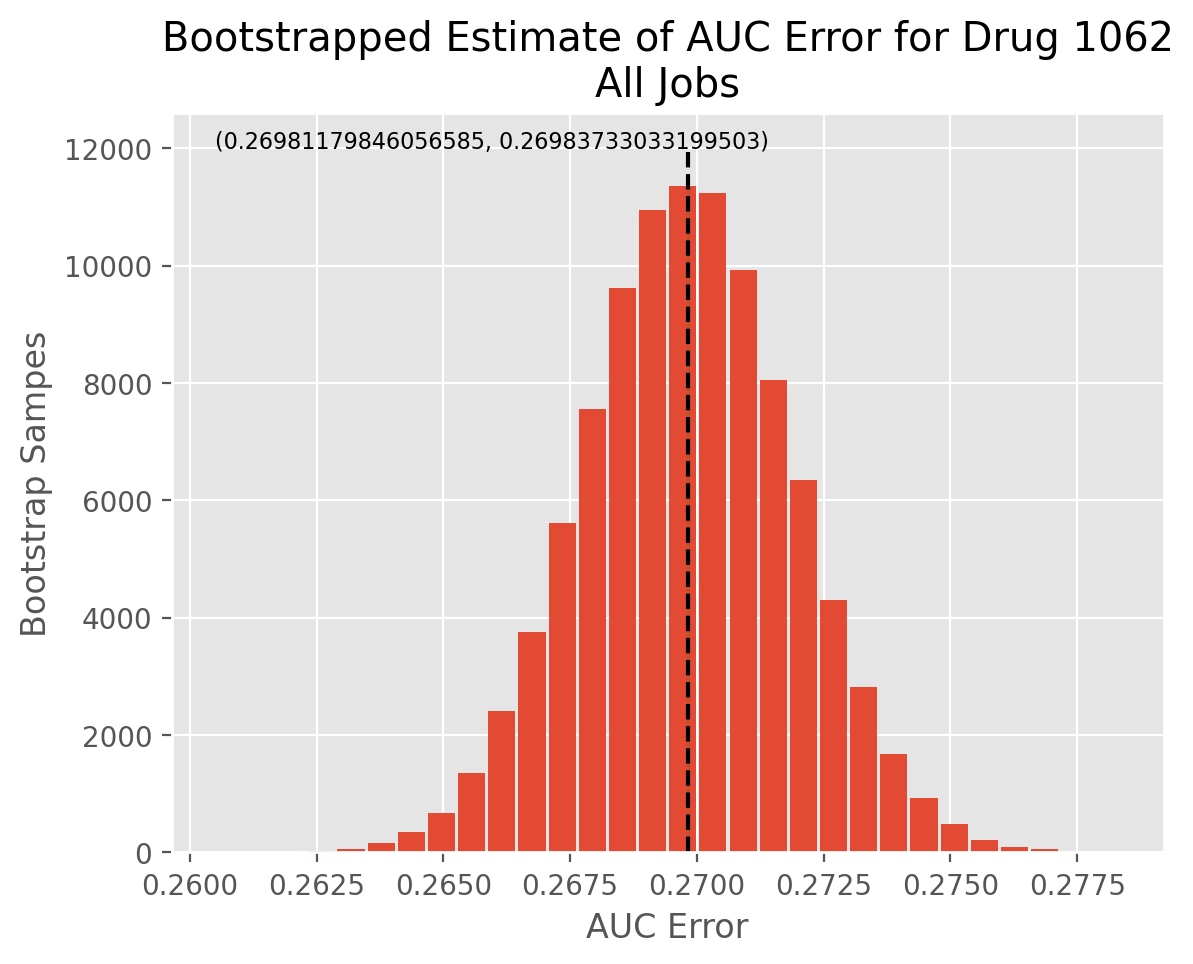

In [47]:
fig, ax = plt.subplots()
confint = st.t.interval(confidence = 0.95, 
                        df = len(boot_all_1062)-1, 
                        loc = np.mean(boot_all_1062), 
                        scale = st.sem(boot_all_1062) )


heights, bins, patches = ax.hist(boot_all_1062, bins=30, rwidth=0.9)
ax.fill_betweenx([0, heights.max()],confint[0], confint[1], alpha = 0.1, color = "g")
ax.vlines(x = np.mean(boot_all_1062), 
          ymin = 0, 
          ymax=12000, 
          colors="black", 
          linestyles="dashed")

ax.text(x = min(boot_all_1062), y = 12000, s = confint, size = 8)
ax.set_title(f"Bootstrapped Estimate of AUC Error for Drug 1062\nAll Jobs")
ax.set_ylabel("Bootstrap Sampes")
ax.set_xlabel("AUC Error")
confint

### Drug 736

In [48]:
path = os.path.join(os.path.join(wd, "data"), "TSVs")
df736 = drug_dict["Drug_736"]
df736

,AUC,Sample,Drug1,PredictedAUC,AUCError
0,0.4912,ACH-000001,Drug_736,0.9884,0.4972
1,0.2607,ACH-000002,Drug_736,0.9620,0.7013
2,0.6061,ACH-000004,Drug_736,0.9789,0.3728
3,0.4877,ACH-000006,Drug_736,0.9487,0.4610
4,0.4755,ACH-000007,Drug_736,0.9835,0.5080
...,...,...,...,...,...
544,0.4936,ACH-001190,Drug_736,0.9803,0.4867
545,0.7583,ACH-001306,Drug_736,0.9829,0.2246
546,0.5376,ACH-001307,Drug_736,0.9762,0.4386
547,0.6033,ACH-001307,Drug_736,0.9786,0.3753


(0.33385942094348187, 0.34732782555014297)

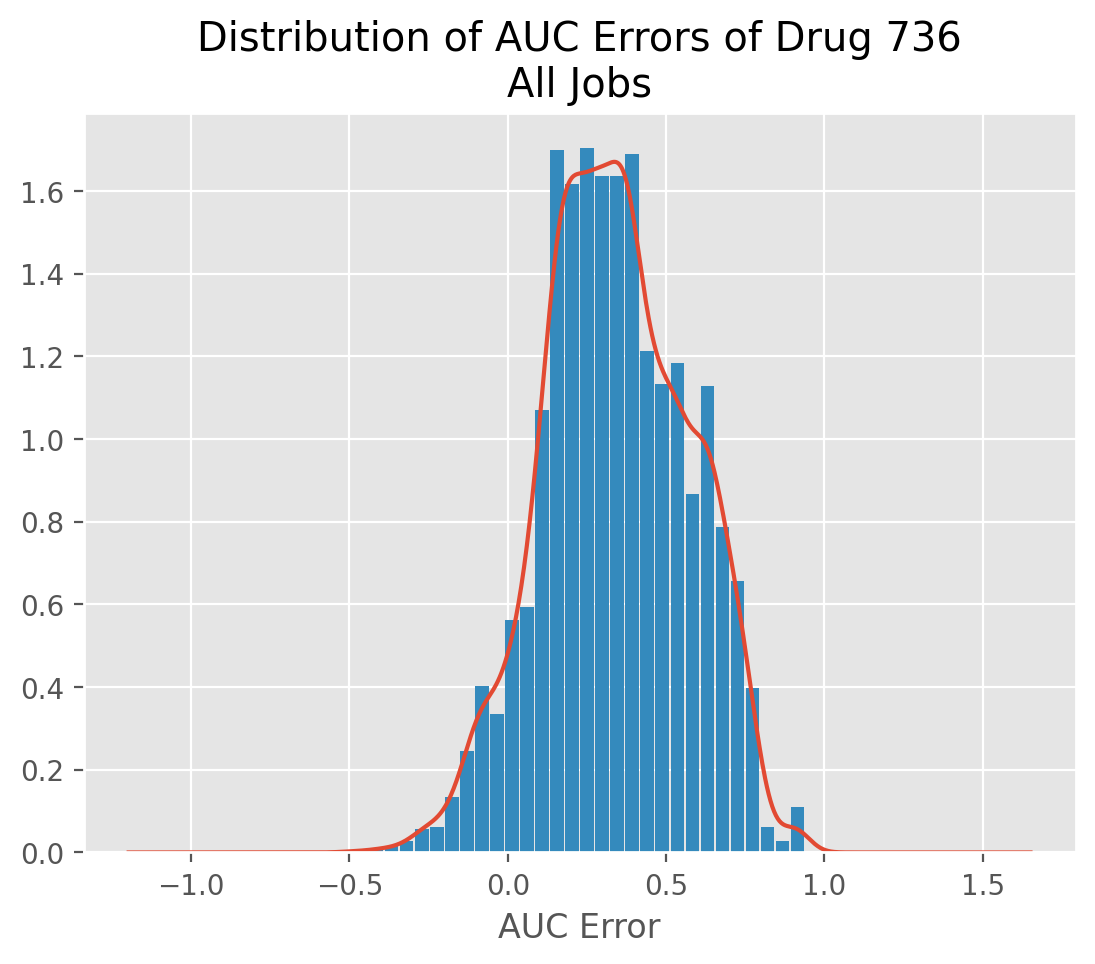

In [49]:
fig, ax1 = plt.subplots()
df736["AUCError"].plot.kde(ax=ax1, 
                            grid = True, )
df736["AUCError"].plot.hist(ax=ax1,
                             density = True, 
                             bins=30, rwidth = 0.9 )
confint = st.t.interval(confidence = 0.95, 
                        df = len(df736["AUCError"])-1, 
                        loc = np.mean(df736["AUCError"]), 
                        scale = st.sem(df736["AUCError"]) )

ax1.set_title(f"Distribution of AUC Errors of Drug 736\nAll Jobs")
ax1.set_ylabel("")
ax1.set_xlabel("AUC Error")
confint

##### Checking Individual Jobs

In [50]:
path = os.path.join(os.path.join(wd, "data"), "TSVs")
dfs_736, jobs_736 = get_all_drug_dfs(drg="Drug_736", path=path)

----------8998707.amn-0001----------


100%|██████████| 12/12 [00:00<00:00, 785.50it/s]


----------8993982.amn-0001----------


100%|██████████| 24/24 [00:00<00:00, 808.60it/s]


----------8991892.amn-0001----------


100%|██████████| 12/12 [00:00<00:00, 774.00it/s]


----------8996461.amn-0001----------


100%|██████████| 480/480 [00:00<00:00, 1109.27it/s]


----------8990757.amn-0001----------


100%|██████████| 24/24 [00:00<00:00, 836.85it/s]


----------8996484.amn-0001----------


100%|██████████| 24/24 [00:00<00:00, 1123.01it/s]


----------8997987.amn-0001----------


100%|██████████| 24/24 [00:00<00:00, 838.46it/s]


----------8999189.amn-0001----------


100%|██████████| 144/144 [00:00<00:00, 973.55it/s]


----------8998722.amn-0001----------


100%|██████████| 144/144 [00:00<00:00, 981.11it/s]


----------8999967.amn-0001----------


100%|██████████| 144/144 [00:00<00:00, 981.09it/s]


----------9000732.amn-0001----------


100%|██████████| 144/144 [00:00<00:00, 979.52it/s]


----------9000896.amn-0001----------


100%|██████████| 144/144 [00:00<00:00, 984.23it/s]


----------8999163.amn-0001----------


100%|██████████| 144/144 [00:00<00:00, 974.03it/s]


----------8998639.amn-0001----------


100%|██████████| 24/24 [00:00<00:00, 886.20it/s]


----------8994056.amn-0001----------


100%|██████████| 216/216 [00:00<00:00, 1045.10it/s]


----------8994012.amn-0001----------


100%|██████████| 36/36 [00:00<00:00, 967.59it/s]


----------9000841.amn-0001----------


100%|██████████| 144/144 [00:00<00:00, 992.51it/s]


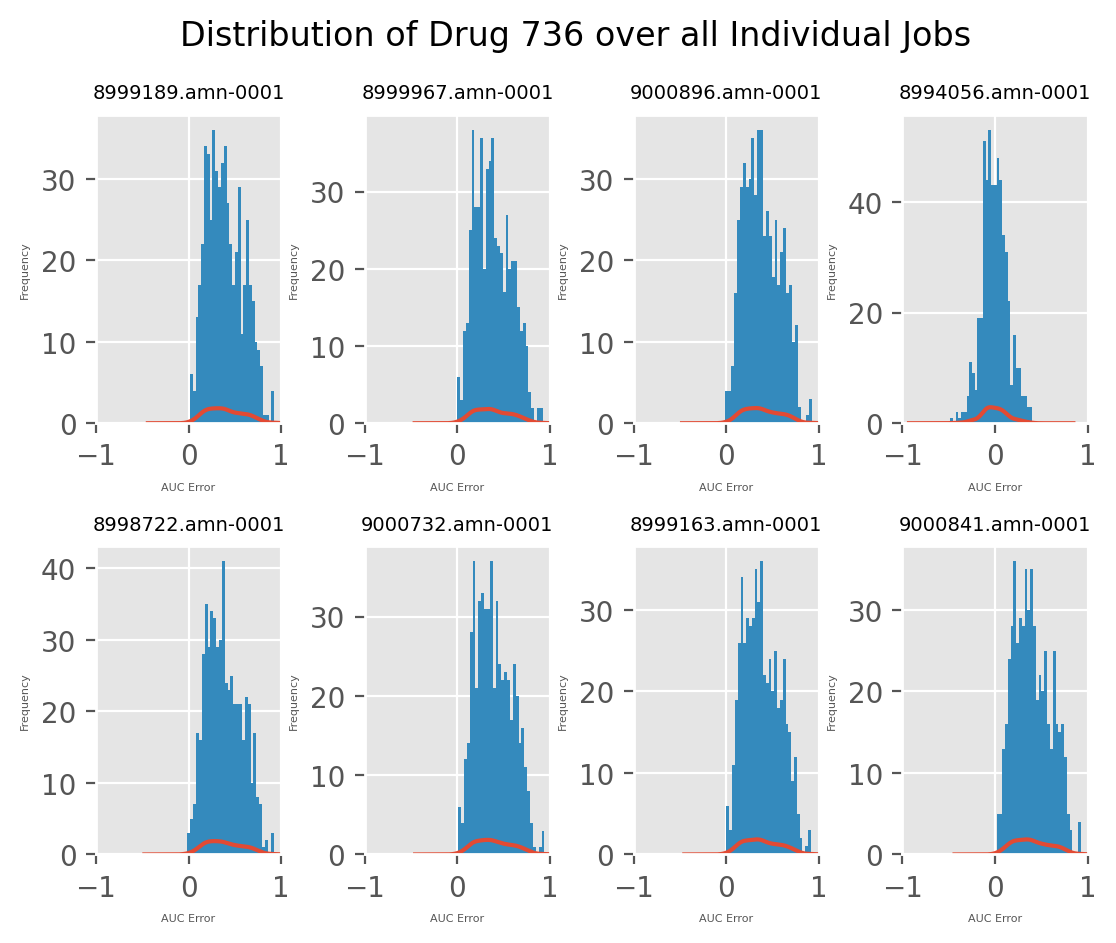

In [51]:
fig, ax1 = plt.subplots(2, 4)
fig.subplots_adjust(hspace=0.4, wspace = 0.45)
fig.suptitle("Distribution of Drug 736 over all Individual Jobs")
k = 0
j = 0

for i, d in enumerate(dfs_736):

    d["AUCError"].plot.kde(ax=ax1[k][j], 
                            grid = True, )
    d["AUCError"].plot.hist(ax=ax1[k][j],
                            density = False, 
                            bins=30, 
                            rwidth = 1, 
                            xlim = (-1, 1))

    ax1[k][j].set_title(f"{jobs_736[i][0]}", size = 7)
    ax1[k][j].set_ylabel("Frequency",size = 4 )
    ax1[k][j].set_xlabel("AUC Error", size = 4)
    k += 1
    k = k % 2
    if k == 0:
        j += 1
    j = j % 4

In [52]:
key_list = ["Job", "Folder", "Mean"]
jobs_perf_736 = {key: [] for key in key_list}



for i, d in enumerate(dfs_736):
    jobs_perf_736["Job"].append(jobs_736[i][0])
    jobs_perf_736["Folder"].append(jobs_736[i][1])
    jobs_perf_736["Mean"].append(np.mean(d["AUCError"]))

jobs_perf_736_df = pd.DataFrame(jobs_perf_736)

# jobs_perf_739_df.sort_values("Mean")
good_perf_jobs_736 = jobs_perf_736_df.sort_values("Mean")[:1]
bad_perf_jobs_736 = jobs_perf_736_df.sort_values("Mean")[1:]


##### Good Jobs

In [53]:
path = os.path.join(os.path.join(wd, "data"), "TSVs")

job_samples_736 = {}

good_jobs_736 = []
for i, row in good_perf_jobs_736.iterrows():
    job = row["Job"]
    # print(job)
    fold = row["Folder"]
    # print(fold)
    file = os.path.join(os.path.join(os.path.join(path, job), fold), "predicted.tsv")
    
    df = pd.read_csv(file, sep="\t")
    good_jobs_736.append(df)
    # print(df)
    samps = df["Sample"].unique()
    
    job_samples_736[job] = set(samps)
    
samps = []
for k, v in job_samples_736.items():
    
    # print(job_samples_988[k])
    samps.append(job_samples_736[k])
    print(len(job_samples_736[k]))

good_jobs_736_df = pd.concat(good_jobs_736)

good_samps_736 = set.intersection(*samps)
print(len(good_samps_736))
good_jobs_736_df

509
509


,AUC,Sample,Drug1,PredictedAUC,AUCError
0,0.4912,ACH-000001,Drug_736,0.5576,0.06641
1,0.2607,ACH-000002,Drug_736,0.3904,0.12970
2,0.6061,ACH-000004,Drug_736,0.3914,-0.21470
3,0.4877,ACH-000006,Drug_736,0.4478,-0.03992
4,0.4755,ACH-000007,Drug_736,0.5922,0.11670
...,...,...,...,...,...
544,0.4936,ACH-001190,Drug_736,0.5223,0.02872
545,0.7583,ACH-001306,Drug_736,0.6179,-0.14040
546,0.5376,ACH-001307,Drug_736,0.6663,0.12870
547,0.6033,ACH-001307,Drug_736,0.6826,0.07929


##### Bad Jobs

In [54]:
path = os.path.join(os.path.join(wd, "data"), "TSVs")

job_samples_736 = {}

bad_jobs_736 = []
for i, row in bad_perf_jobs_736.iterrows():
    job = row["Job"]
    # print(job)
    fold = row["Folder"]
    # print(fold)
    file = os.path.join(os.path.join(os.path.join(path, job), fold), "predicted.tsv")
    
    df = pd.read_csv(file, sep="\t")
    bad_jobs_736.append(df)
    # print(df)
    samps = df["Sample"].unique()
    
    job_samples_736[job] = set(samps)
    
samps = []
for k, v in job_samples_736.items():
    
    # print(job_samples_988[k])
    samps.append(job_samples_736[k])
    # print(len(job_samples_988[k]))
bad_jobs_1079_df = pd.concat(bad_jobs_736)
bad_samps_1079 = set.intersection(*samps)
print(len(good_samps_736.symmetric_difference(bad_samps_1079)))
bad_jobs_1079_df

0


,AUC,Sample,Drug1,PredictedAUC,AUCError
0,0.4912,ACH-000001,Drug_736,0.9575,0.4663
1,0.2607,ACH-000002,Drug_736,0.9943,0.7336
2,0.6061,ACH-000004,Drug_736,0.9484,0.3423
3,0.4877,ACH-000006,Drug_736,0.9223,0.4346
4,0.4755,ACH-000007,Drug_736,0.9697,0.4942
...,...,...,...,...,...
544,0.4936,ACH-001190,Drug_736,0.9803,0.4867
545,0.7583,ACH-001306,Drug_736,0.9829,0.2246
546,0.5376,ACH-001307,Drug_736,0.9762,0.4386
547,0.6033,ACH-001307,Drug_736,0.9786,0.3753


##### T Test

In [55]:
st.ttest_ind(good_jobs_736_df["AUCError"], bad_jobs_1079_df["AUCError"], equal_var = False)

Ttest_indResult(statistic=-58.11803171485784, pvalue=9.78174558037155e-303)

#### Bootstrapping

In [56]:
boot_all_736 = boostraped_rmse(df736["AUCError"], 100000, np.mean)

100%|██████████| 100000/100000 [00:09<00:00, 10222.65it/s]


(0.4096090381490245, 0.40964706071169776)

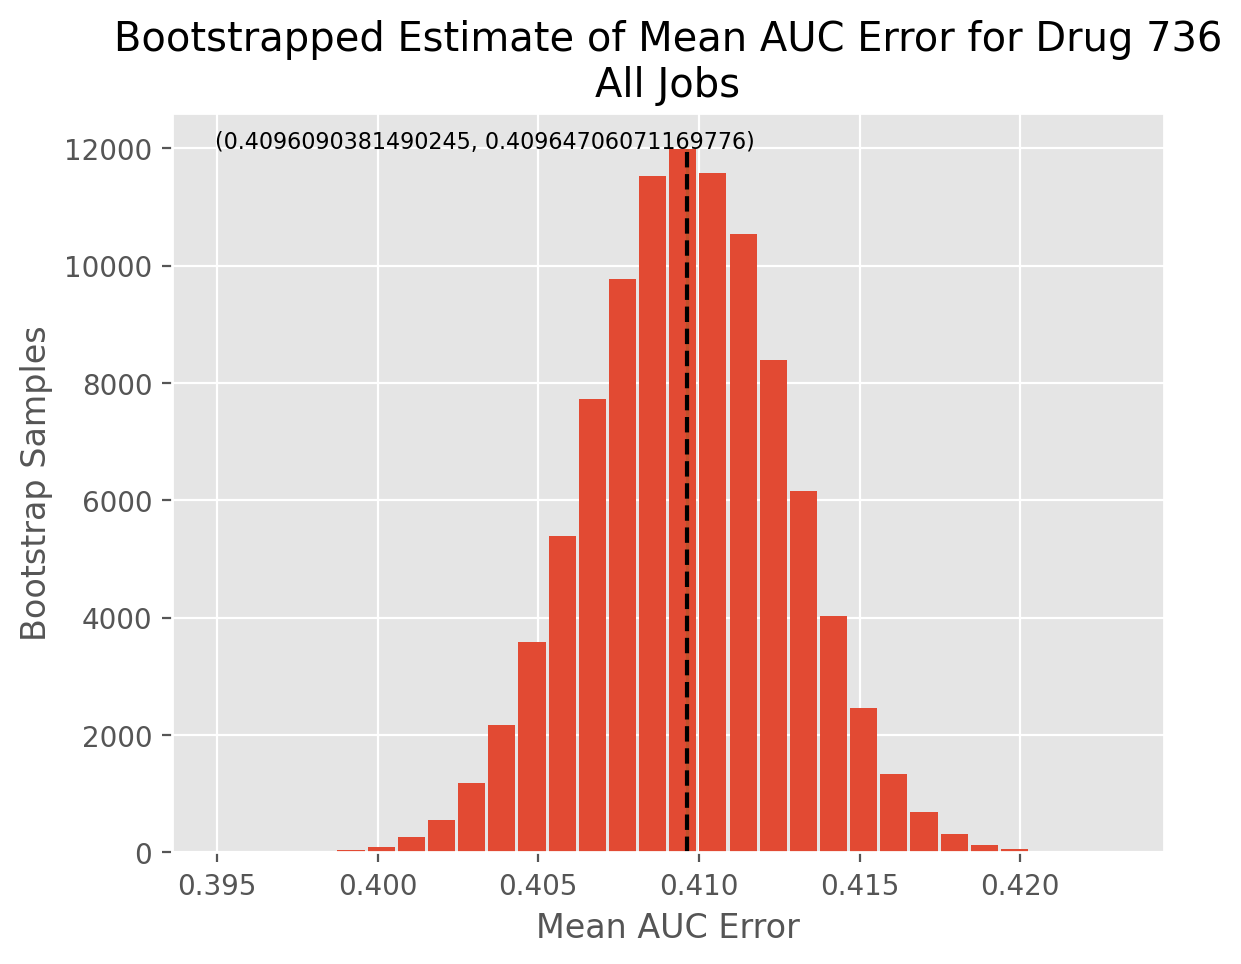

In [57]:
fig, ax = plt.subplots()
confint = st.t.interval(confidence = 0.95, 
                        df = len(boot_all_736)-1, 
                        loc = np.mean(boot_all_736), 
                        scale = st.sem(boot_all_736) 
)


heights, bins, patches = ax.hist(boot_all_736, bins=30, rwidth=0.9)
ax.fill_betweenx([0, heights.max()],
                 confint[0], 
                 confint[1], 
                 alpha = 0.1, 
                 color = "g"
)

ax.vlines(x = np.mean(boot_all_736), 
          ymin = 0, 
          ymax=12000, 
          colors="black", 
          linestyles="dashed"
)

ax.text(x = min(boot_all_736), y = 12000, s = confint, size = 8)
ax.set_title(f"Bootstrapped Estimate of Mean AUC Error for Drug 736\nAll Jobs")
ax.set_ylabel("Bootstrap Samples")
ax.set_xlabel("Mean AUC Error")
confint

### Drug 1079

In [58]:
path = os.path.join(os.path.join(wd, "data"), "TSVs")
df1079 = drug_dict["Drug_1079"]
df1079

,AUC,Sample,Drug1,PredictedAUC,AUCError
0,0.2267,ACH-000002,Drug_1079,0.9013,0.6746
1,0.6248,ACH-000004,Drug_1079,0.8150,0.1902
2,0.5663,ACH-000005,Drug_1079,0.8142,0.2479
3,0.5071,ACH-000006,Drug_1079,0.8399,0.3328
4,0.3328,ACH-000007,Drug_1079,0.9025,0.5697
...,...,...,...,...,...
703,0.2461,ACH-001129,Drug_1079,0.7822,0.5361
704,0.6123,ACH-001239,Drug_1079,0.7742,0.1619
705,0.3899,ACH-001306,Drug_1079,0.7275,0.3376
706,0.5886,ACH-001307,Drug_1079,0.7211,0.1325


(0.32350163779513685, 0.33547790016390266)

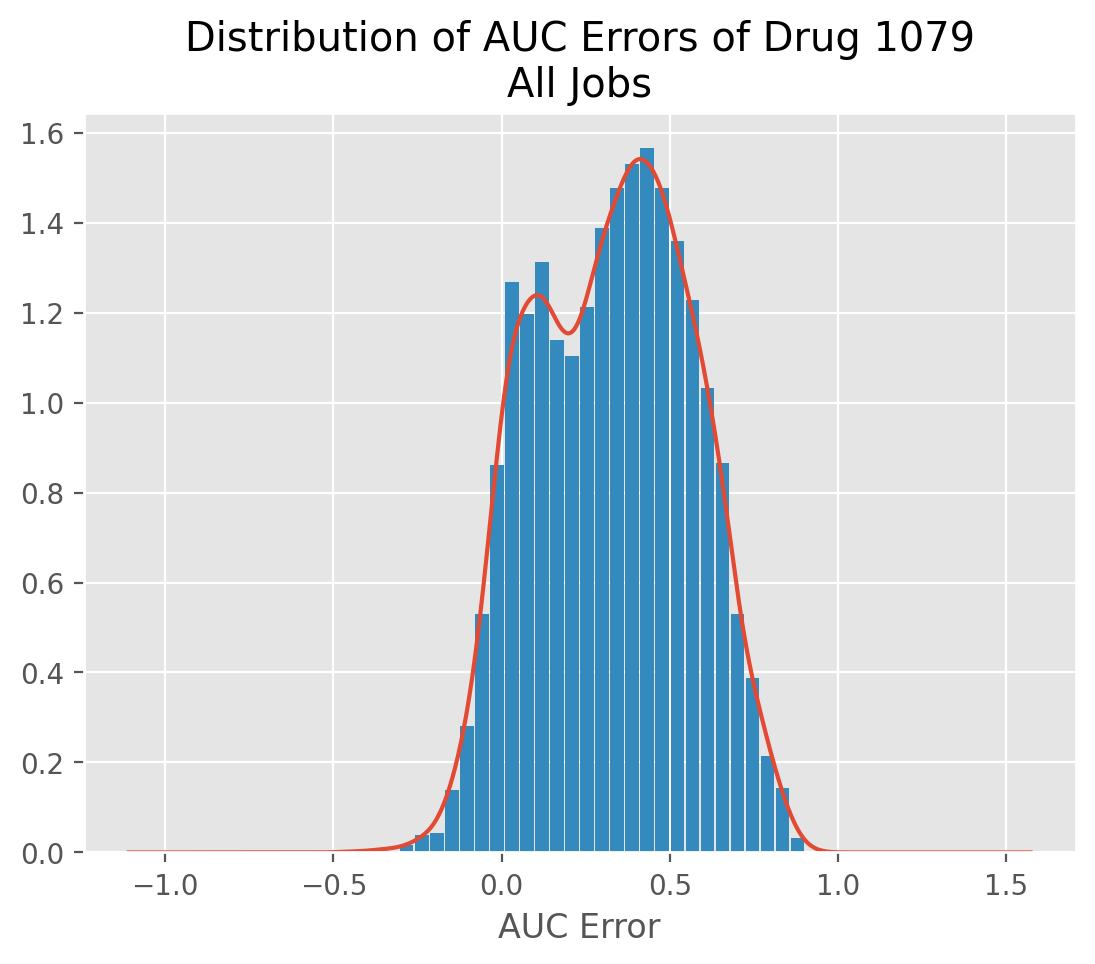

In [59]:
fig, ax1 = plt.subplots()
df1079["AUCError"].plot.kde(ax=ax1, 
                            grid = True, )
df1079["AUCError"].plot.hist(ax=ax1,
                             density = True, 
                             bins=30, rwidth = 0.9 )
confint = st.t.interval(confidence = 0.95, 
                        df = len(df1079["AUCError"])-1, 
                        loc = np.mean(df1079["AUCError"]), 
                        scale = st.sem(df1079["AUCError"]) )

ax1.set_title(f"Distribution of AUC Errors of Drug 1079\nAll Jobs")
ax1.set_ylabel("")
ax1.set_xlabel("AUC Error")
confint

#### Is 1079 Bimodal?

In [60]:
path = os.path.join(os.path.join(wd, "data"), "TSVs")
dfs_1079, jobs_1079 = get_all_drug_dfs(drg="Drug_1079", path=path)

----------8998707.amn-0001----------


100%|██████████| 12/12 [00:00<00:00, 815.72it/s]


----------8993982.amn-0001----------


100%|██████████| 24/24 [00:00<00:00, 802.33it/s]


----------8991892.amn-0001----------


100%|██████████| 12/12 [00:00<00:00, 801.03it/s]


----------8996461.amn-0001----------


100%|██████████| 480/480 [00:00<00:00, 1120.33it/s]


----------8990757.amn-0001----------


100%|██████████| 24/24 [00:00<00:00, 828.42it/s]


----------8996484.amn-0001----------


100%|██████████| 24/24 [00:00<00:00, 1113.48it/s]


----------8997987.amn-0001----------


100%|██████████| 24/24 [00:00<00:00, 834.35it/s]


----------8999189.amn-0001----------


100%|██████████| 144/144 [00:00<00:00, 976.99it/s]


----------8998722.amn-0001----------


100%|██████████| 144/144 [00:00<00:00, 978.90it/s]


----------8999967.amn-0001----------


100%|██████████| 144/144 [00:00<00:00, 995.84it/s] 


----------9000732.amn-0001----------


100%|██████████| 144/144 [00:00<00:00, 970.15it/s]


----------9000896.amn-0001----------


100%|██████████| 144/144 [00:00<00:00, 980.37it/s]


----------8999163.amn-0001----------


100%|██████████| 144/144 [00:00<00:00, 991.24it/s] 


----------8998639.amn-0001----------


100%|██████████| 24/24 [00:00<00:00, 863.49it/s]


----------8994056.amn-0001----------


100%|██████████| 216/216 [00:00<00:00, 1037.78it/s]


----------8994012.amn-0001----------


100%|██████████| 36/36 [00:00<00:00, 944.52it/s]


----------9000841.amn-0001----------


100%|██████████| 144/144 [00:00<00:00, 703.37it/s]


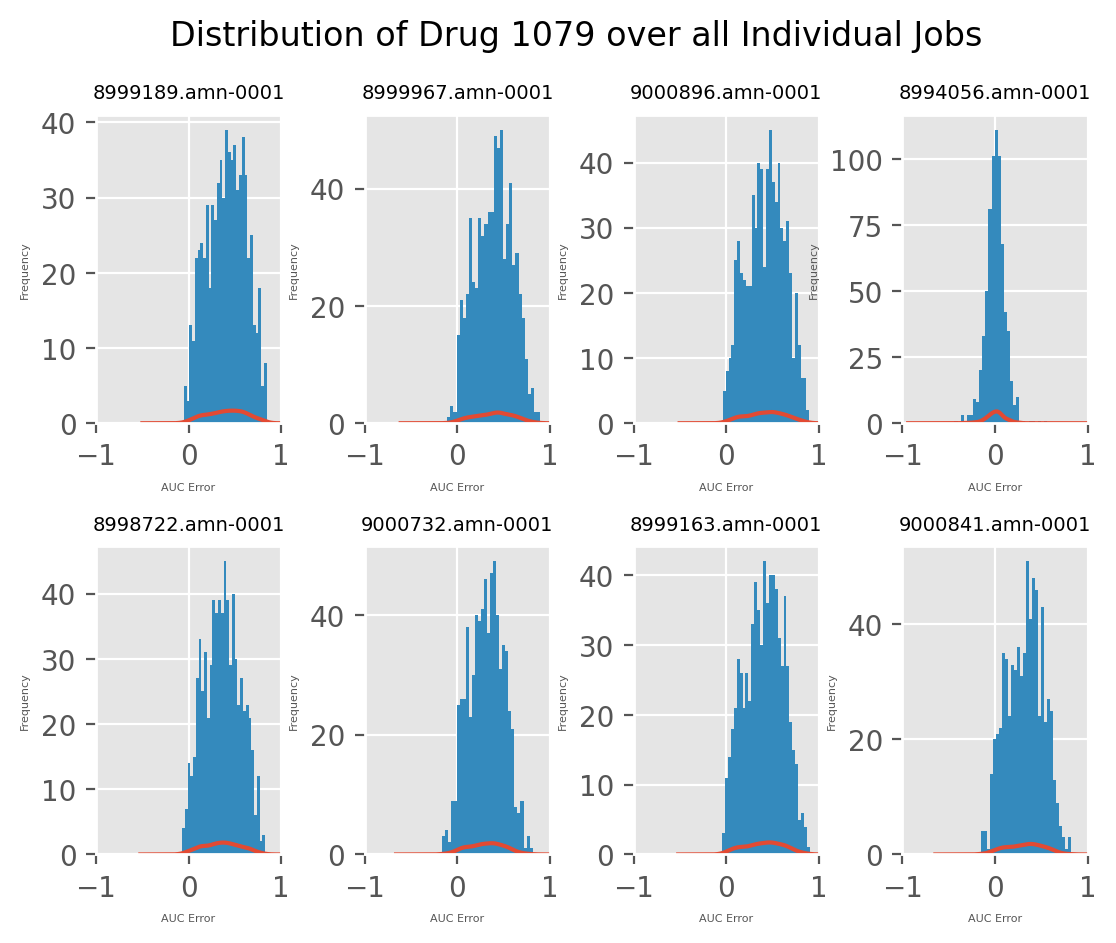

In [61]:
fig, ax1 = plt.subplots(2,4)
fig.subplots_adjust(hspace=0.4, wspace = 0.45)
fig.suptitle("Distribution of Drug 1079 over all Individual Jobs")
k = 0
j = 0
for i, d in enumerate(dfs_1079):
    # print(f"PRE: {k, j}")
    d["AUCError"].plot.kde(ax=ax1[k][j], 
                            grid = True, )
    d["AUCError"].plot.hist(ax=ax1[k][j],
                        density = False, 
                        bins=30, 
                        rwidth = 1, 
                        xlim = (-1, 1))
    ax1[k][j].set_title(f"{jobs_1079[i][0]}", size = 7)
    ax1[k][j].set_ylabel("Frequency",size = 4 )
    ax1[k][j].set_xlabel("AUC Error", size = 4)
    k += 1
    k = k % 2
    if k == 0:
        j += 1
    j = j % 4
    
    # print(k, j)
    
    
    # ax1[i][j].set_xlabel("AUC Error")

In [62]:

key_list = ["Job", "Folder", "Mean"]
jobs_perf_1079 = {key: [] for key in key_list}



for i, d in enumerate(dfs_1079):
    jobs_perf_1079["Job"].append(jobs_1079[i][0])
    jobs_perf_1079["Folder"].append(jobs_1079[i][1])
    jobs_perf_1079["Mean"].append(np.mean(d["AUCError"]))

jobs_perf_1079_df = pd.DataFrame(jobs_perf_1079)


good_perf_jobs_1079 = jobs_perf_1079_df.sort_values("Mean")[:1]
bad_perf_jobs_1079 = jobs_perf_1079_df.sort_values("Mean")[1:]

# jobs_perf_1079_df.sort_values("Mean")
bad_perf_jobs_1079

,Job,Folder,Mean
3,9000732.amn-0001,116,0.310953
7,9000841.amn-0001,116,0.321560
1,8998722.amn-0001,116,0.363212
2,8999967.amn-0001,116,0.390680
5,8999163.amn-0001,116,0.407260
0,8999189.amn-0001,116,0.410034
4,9000896.amn-0001,116,0.424948


##### Good Performing Jobs

In [63]:
path = os.path.join(os.path.join(wd, "data"), "TSVs")

job_samples_1079 = {}

good_jobs_1079 = []
for i, row in good_perf_jobs_1079.iterrows():
    job = row["Job"]
    # print(job)
    fold = row["Folder"]
    # print(fold)
    file = os.path.join(os.path.join(os.path.join(path, job), fold), "predicted.tsv")
    
    df = pd.read_csv(file, sep="\t")
    good_jobs_1079.append(df)
    # print(df)
    samps = df["Sample"].unique()
    
    job_samples_1079[job] = set(samps)
    
samps = []
for k, v in job_samples_1079.items():
    
    # print(job_samples_988[k])
    samps.append(job_samples_1079[k])
    print(len(job_samples_1079[k]))

good_jobs_1079_df = pd.concat(good_jobs_1079)

good_samps_1079 = set.intersection(*samps)
print(len(good_samps_1079))
good_jobs_1079_df

695
695


,AUC,Sample,Drug1,PredictedAUC,AUCError
0,0.2267,ACH-000002,Drug_1079,0.2531,0.026360
1,0.6248,ACH-000004,Drug_1079,0.5508,-0.074000
2,0.5663,ACH-000005,Drug_1079,0.4123,-0.154000
3,0.5071,ACH-000006,Drug_1079,0.3378,-0.169300
4,0.3328,ACH-000007,Drug_1079,0.3101,-0.022680
...,...,...,...,...,...
703,0.2461,ACH-001129,Drug_1079,0.2721,0.026010
704,0.6123,ACH-001239,Drug_1079,0.5315,-0.080760
705,0.3899,ACH-001306,Drug_1079,0.5500,0.160100
706,0.5886,ACH-001307,Drug_1079,0.5976,0.008968


##### Bad Performing Jobs

In [64]:
path = os.path.join(os.path.join(wd, "data"), "TSVs")

job_samples_1079 = {}

bad_jobs_1079 = []
for i, row in bad_perf_jobs_1079.iterrows():
    job = row["Job"]
    # print(job)
    fold = row["Folder"]
    # print(fold)
    file = os.path.join(os.path.join(os.path.join(path, job), fold), "predicted.tsv")
    
    df = pd.read_csv(file, sep="\t")
    bad_jobs_1079.append(df)
    # print(df)
    samps = df["Sample"].unique()
    
    job_samples_1079[job] = set(samps)
    
samps = []
for k, v in job_samples_1079.items():
    
    # print(job_samples_988[k])
    samps.append(job_samples_1079[k])
    # print(len(job_samples_988[k]))
bad_jobs_1079_df = pd.concat(bad_jobs_1079)
bad_samps_1079 = set.intersection(*samps)
print(len(good_samps_1079.symmetric_difference(bad_samps_1079)))
bad_jobs_1079_df

0


,AUC,Sample,Drug1,PredictedAUC,AUCError
0,0.2267,ACH-000002,Drug_1079,0.7687,0.54200
1,0.6248,ACH-000004,Drug_1079,0.7008,0.07605
2,0.5663,ACH-000005,Drug_1079,0.6867,0.12040
3,0.5071,ACH-000006,Drug_1079,0.7230,0.21590
4,0.3328,ACH-000007,Drug_1079,0.7314,0.39860
...,...,...,...,...,...
703,0.2461,ACH-001129,Drug_1079,0.7638,0.51770
704,0.6123,ACH-001239,Drug_1079,0.9013,0.28900
705,0.3899,ACH-001306,Drug_1079,0.8686,0.47870
706,0.5886,ACH-001307,Drug_1079,0.8848,0.29620


##### T Test

In [65]:
st.ttest_ind(good_jobs_1079_df["AUCError"], bad_jobs_1079_df["AUCError"], equal_var = False)

Ttest_indResult(statistic=-75.46630403201247, pvalue=0.0)

#### Bootstrapped

In [66]:
boot_all_1079 = boostraped_rmse(df1079["AUCError"], 100000, np.mean)

100%|██████████| 100000/100000 [00:08<00:00, 11303.15it/s]


(0.40174386454270533, 0.40177660800741427)

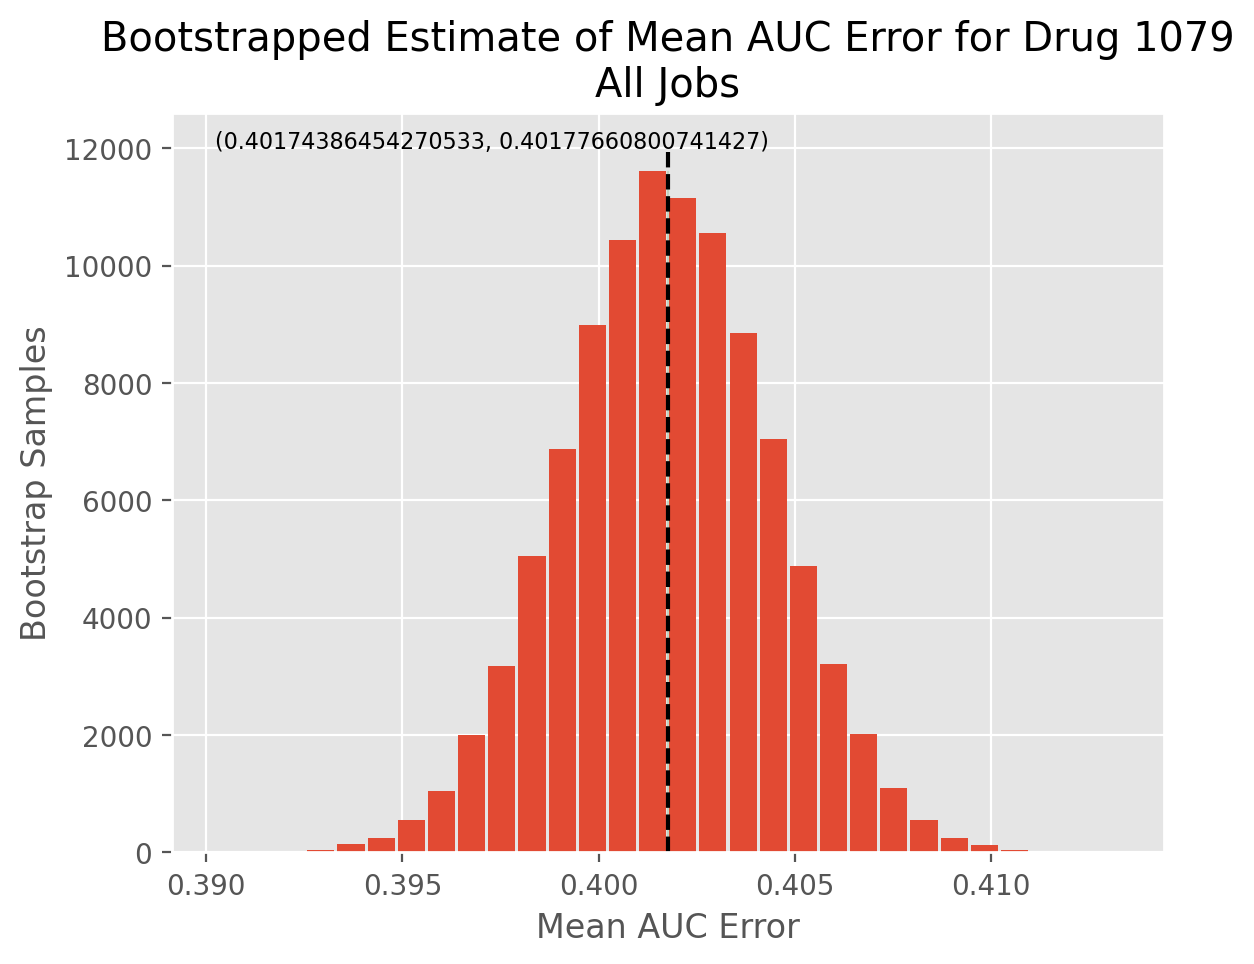

In [67]:
fig, ax = plt.subplots()
confint = st.t.interval(confidence = 0.95, 
                        df = len(boot_all_1079)-1, 
                        loc = np.mean(boot_all_1079), 
                        scale = st.sem(boot_all_1079) )


heights, bins, patches = ax.hist(boot_all_1079, bins=30, rwidth=0.9)
ax.fill_betweenx([0, heights.max()],confint[0], confint[1], alpha = 0.1, color = "g")
ax.vlines(x = np.mean(boot_all_1079), 
          ymin = 0, 
          ymax=12000, 
          colors="black", 
          linestyles="dashed")

ax.text(x = min(boot_all_1079), y = 12000, s = confint, size = 8)
ax.set_title(f"Bootstrapped Estimate of Mean AUC Error for Drug 1079\nAll Jobs")
ax.set_ylabel("Bootstrap Samples")
ax.set_xlabel("Mean AUC Error")
confint

## Sample Analysis 

### Worst Performing Samples

In [68]:
samples_rmse_curr = {}
job_samples = []

samples_perf = {}
for job in os.listdir(path):
    curr = os.path.join(path, job)
    
    print(f"----------{job}----------")
    job_samples.append(job_samples)
    samples_rmse_curr = {}
    
    for model in tqdm.tqdm(os.listdir(curr)):
        inner = os.path.join(curr, model)
        
        for subdir, dirs, files in os.walk(inner):
            for file in files:
                f = os.path.join(subdir, file)
                df = pd.read_csv(f, sep="\t")
                
                samples_curr = df["Sample"].unique()
                
                for s in samples_curr: 
                    s_df = df[df["Sample"] == s]

                    if s not in samples_perf:
                        samples_perf[s] = []
                        samples_perf[s].append(s_df)
                    else:
                        samples_perf[s].append(s_df)
                    

----------8998707.amn-0001----------


100%|██████████| 12/12 [00:01<00:00, 10.60it/s]


----------8993982.amn-0001----------


100%|██████████| 24/24 [00:03<00:00,  7.92it/s]


----------8991892.amn-0001----------


100%|██████████| 12/12 [00:01<00:00,  8.68it/s]


----------8996461.amn-0001----------


100%|██████████| 480/480 [00:37<00:00, 12.79it/s]


----------8990757.amn-0001----------


100%|██████████| 24/24 [00:02<00:00,  8.68it/s]


----------8996484.amn-0001----------


100%|██████████| 24/24 [00:01<00:00, 16.09it/s]


----------8997987.amn-0001----------


100%|██████████| 24/24 [00:02<00:00,  8.95it/s]


----------8999189.amn-0001----------


100%|██████████| 144/144 [00:13<00:00, 10.36it/s]


----------8998722.amn-0001----------


100%|██████████| 144/144 [00:14<00:00,  9.76it/s]


----------8999967.amn-0001----------


100%|██████████| 144/144 [00:14<00:00,  9.83it/s]


----------9000732.amn-0001----------


100%|██████████| 144/144 [00:13<00:00, 10.64it/s]


----------9000896.amn-0001----------


100%|██████████| 144/144 [00:14<00:00,  9.95it/s]


----------8999163.amn-0001----------


100%|██████████| 144/144 [00:13<00:00, 10.59it/s]


----------8998639.amn-0001----------


100%|██████████| 24/24 [00:02<00:00,  9.34it/s]


----------8994056.amn-0001----------


100%|██████████| 216/216 [00:20<00:00, 10.65it/s]


----------8994012.amn-0001----------


100%|██████████| 36/36 [00:03<00:00, 10.82it/s]


----------9000841.amn-0001----------


100%|██████████| 144/144 [00:13<00:00, 10.57it/s]


In [69]:
s_000939 = pd.concat(samples_perf["ACH-000939"])

In [70]:
sample_dict = {}
for key, value in tqdm.tqdm(samples_perf.items()):
    sample_dict[key] = pd.concat(value)
    # print(len(value))



100%|██████████| 785/785 [01:08<00:00, 11.43it/s]


In [71]:
key_list = ["Sample", "RMSE", "n"]
samples_rmse = {key: [] for key in key_list}


for key, value in sample_dict.items(): 
    samples_rmse["Sample"].append(key)
    curr_rmse = mean_squared_error(value["AUC"], value["PredictedAUC"], squared=False)
    samples_rmse["RMSE"].append(curr_rmse)
    samples_rmse["n"].append(len(value))


In [72]:
all_samples_df = pd.DataFrame(samples_rmse).sort_values(["n", "RMSE"], ascending=False)

In [73]:
pd.DataFrame(samples_rmse).sort_values(["RMSE"], ascending=False)

,Sample,RMSE,n
784,ACH-000041,0.411644,23
783,ACH-000659,0.215101,114
50,ACH-000112,0.184083,1911
765,ACH-000923,0.175146,217
590,ACH-000310,0.173799,1040
...,...,...,...
780,ACH-000164,0.072594,230
565,ACH-000180,0.071041,1193
702,ACH-000791,0.067149,1108
643,ACH-000517,0.064502,1102


Text(0.5, 0, 'Samples')

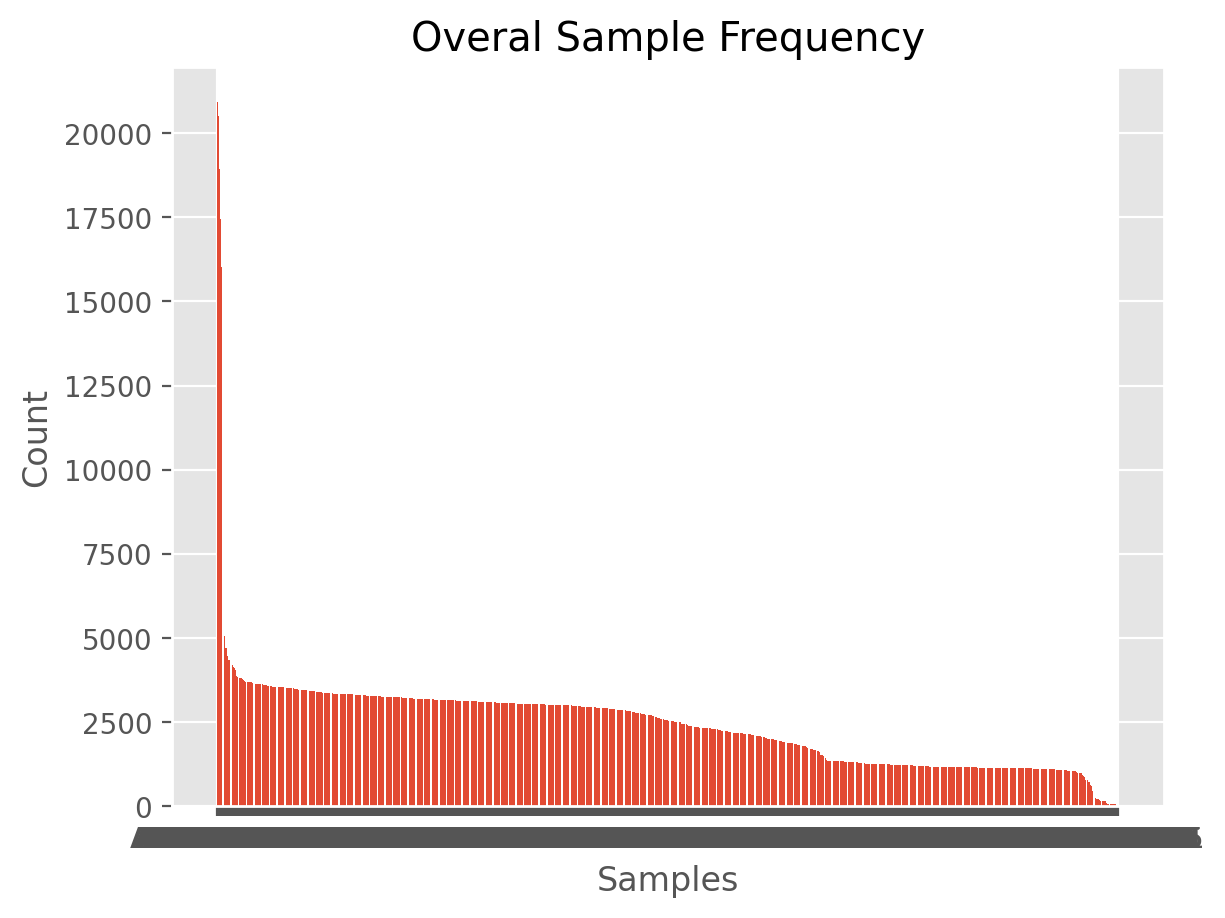

In [74]:
fig, ax = plt.subplots()

ax.bar(all_samples_df["Sample"], all_samples_df["n"])
# ax.plot(all_samples_df["Sample"], all_samples_df["n"], color = "blue")
ax.set_title("Overal Sample Frequency")
ax.set_ylabel("Count")
ax.set_xlabel("Samples")

In [75]:
# sample_dict["ACH-000041"].sort_values("AUCError", ascending = False, key = np.abs)
summ = 0
for value in sample_dict.values():
    summ += len(value)
    
print(summ)

1914073


### Sample ACH-000219

In [76]:
b_219 = boostraped_rmse(sample_dict["ACH-000219"]["AUCError"], 100000, np.mean)

100%|██████████| 100000/100000 [00:33<00:00, 2942.22it/s]


(0.1426115425377326, 0.14262901711582573)

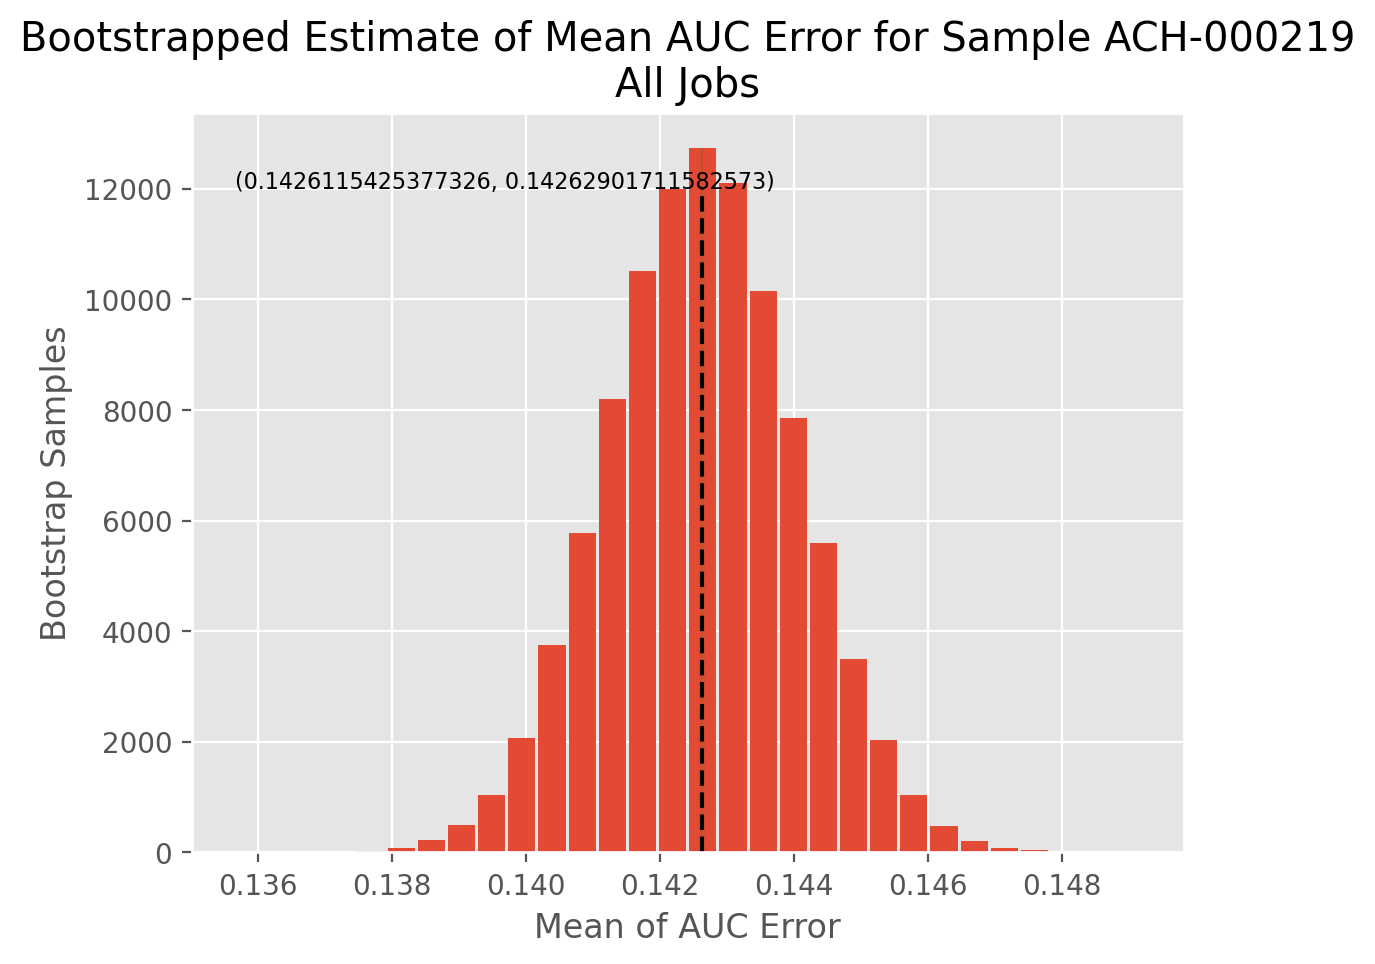

In [77]:
fig, ax = plt.subplots()
confint = st.t.interval(confidence = 0.95, 
                        df = len(b_219)-1, 
                        loc = np.mean(b_219), 
                        scale = st.sem(b_219) )

heights, bins, patches = ax.hist(b_219, bins=30, rwidth=0.9)

ax.fill_betweenx([0, heights.max()],confint[0], confint[1], alpha = 0.1, color = "g")
ax.vlines(x = np.mean(b_219), 
          ymin = 0, 
          ymax=12000, 
          colors="black", 
          linestyles="dashed")
ax.text(x = min(b_219), y = 12000, s = confint, size = 8)
ax.set_title(f"Bootstrapped Estimate of Mean AUC Error for Sample ACH-000219\nAll Jobs")
ax.set_ylabel("Bootstrap Samples")
ax.set_xlabel("Mean of AUC Error")
confint

### Sample ACH-000041

In [78]:
samp_41 = sample_dict["ACH-000041"]
b_41 = boostraped_rmse(samp_41["AUCError"], 100000, np.mean)

100%|██████████| 100000/100000 [00:01<00:00, 76143.95it/s]


(0.23102630177506714, 0.44119021996406327)

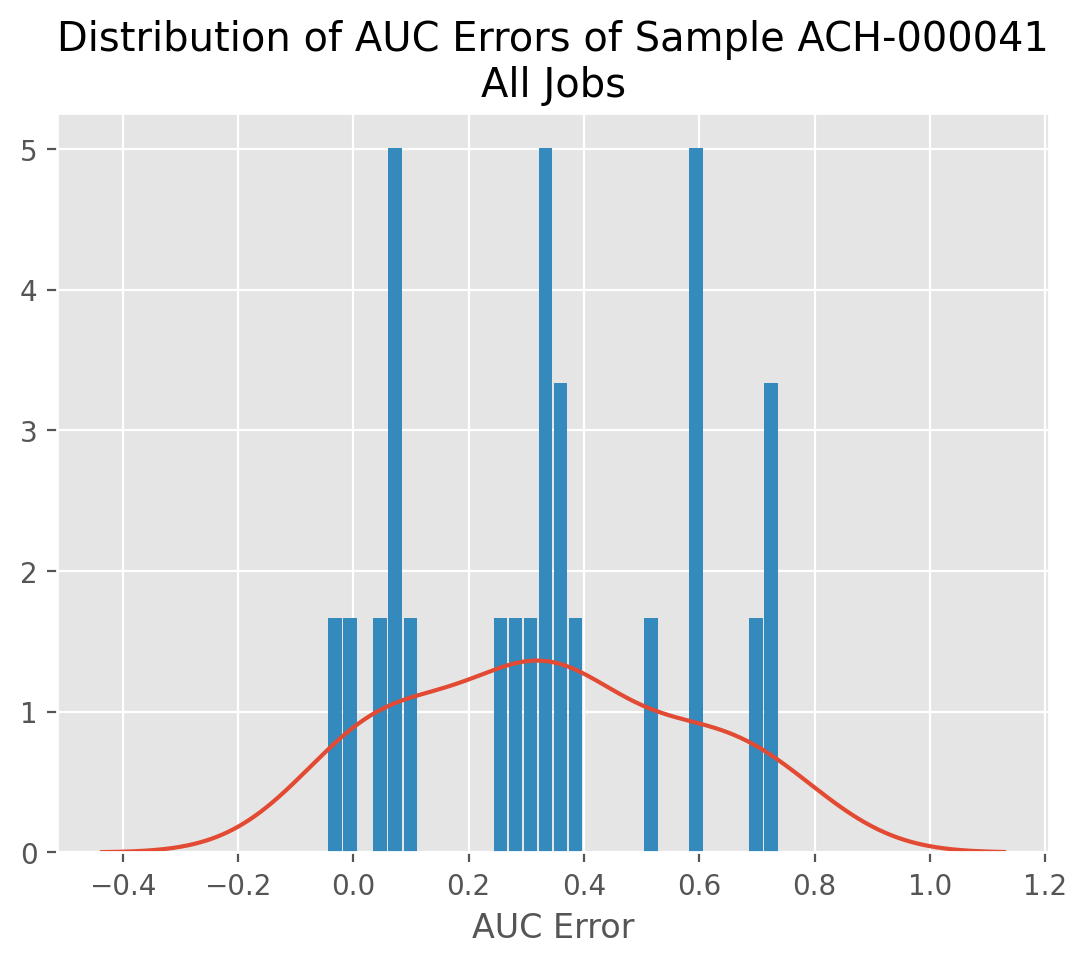

In [79]:
fig, ax1 = plt.subplots()
confint = st.t.interval(confidence = 0.95, 
                        df = len(samp_41["AUCError"])-1, 
                        loc = np.mean(samp_41["AUCError"]), 
                        scale = st.sem(samp_41["AUCError"]) )

samp_41["AUCError"].plot.kde(ax=ax1, 
                            grid = True, )
samp_41["AUCError"].plot.hist(ax=ax1,
                             density = True, 
                             bins=30, rwidth = 0.9 )
ax.fill_betweenx([0, 5],confint[0], confint[1], alpha = 1, color = "g")
ax1.set_title(f"Distribution of AUC Errors of Sample ACH-000041\nAll Jobs")
ax1.set_ylabel("")
ax1.set_xlabel("AUC Error")
confint

(0.409014062832212, 0.4095726362184793)

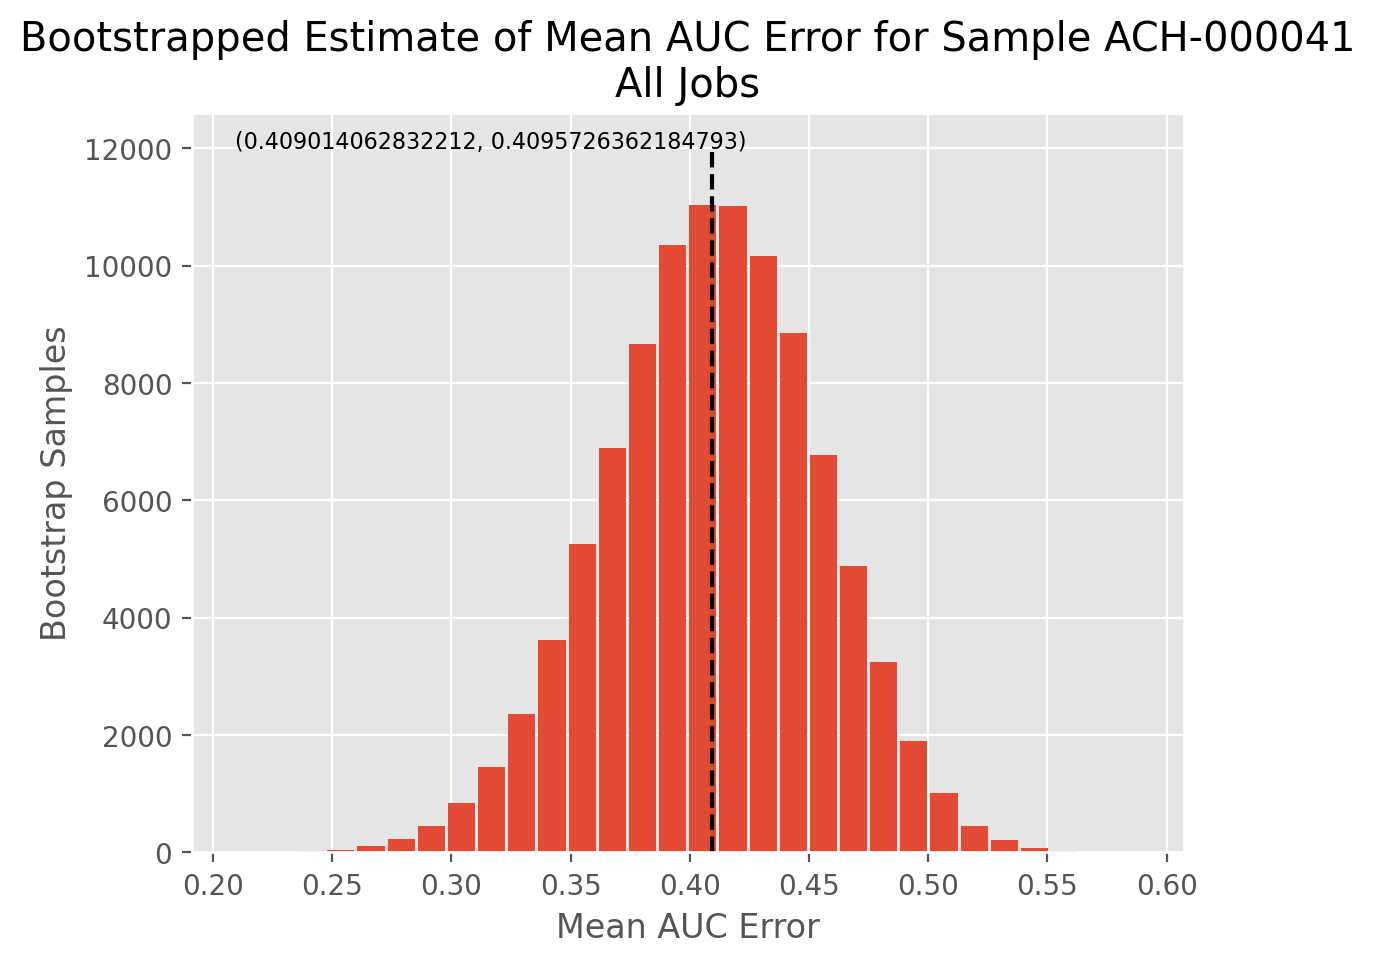

In [80]:
fig, ax = plt.subplots()
confint = st.t.interval(confidence = 0.95, 
                        df = len(b_41)-1, 
                        loc = np.mean(b_41), 
                        scale = st.sem(b_41) )


heights, bins, patches = ax.hist(b_41, bins=30, rwidth=0.9)
ax.fill_betweenx([0, heights.max()],confint[0], confint[1], alpha = 0.1, color = "g")
ax.vlines(x = np.mean(b_41), 
          ymin = 0, 
          ymax=12000, 
          colors="black", 
          linestyles="dashed")
ax.text(x = min(b_41), y = 12000, s = confint, size = 8)
ax.set_title(f"Bootstrapped Estimate of Mean AUC Error for Sample ACH-000041\nAll Jobs")
ax.set_ylabel("Bootstrap Samples")
ax.set_xlabel("Mean AUC Error")
confint

### Drug 988 Samples

In [81]:
df_988 = get_all_df_drug("Drug_988", path=path)

In [82]:
df_988

,AUC,Sample,Drug1,PredictedAUC,AUCError
0,0.2903,ACH-000001,Drug_988,0.3877,0.09742
1,0.2636,ACH-000002,Drug_988,0.3540,0.09037
2,0.2858,ACH-000002,Drug_988,0.3546,0.06882
3,0.2929,ACH-000002,Drug_988,0.3565,0.06357
4,0.3114,ACH-000002,Drug_988,0.3711,0.05973
...,...,...,...,...,...
1896,0.3578,ACH-001307,Drug_988,0.9452,0.58740
1897,0.4194,ACH-001307,Drug_988,0.9288,0.50940
1898,0.3146,ACH-001318,Drug_988,0.9436,0.62900
1899,0.6505,ACH-001318,Drug_988,0.9672,0.31670


In [115]:
df_988["Sample"].nunique()

df_988[["Sample", "AUCError"]]

df_988_worst_tumor = df_988[["Sample", "AUCError"]].sort_values("AUCError", ascending=False, key=np.abs)
df_988_worst_tumor
# df_988_worst_tumor[df_988_worst_tumor["Sample"] == "ACH-000939"]

,Sample,AUCError
1745,ACH-000939,0.908000
1745,ACH-000939,0.903200
1745,ACH-000939,0.896200
17,ACH-000008,0.894000
1745,ACH-000939,0.887900
...,...,...
86,ACH-000059,-0.000091
1173,ACH-000651,-0.000087
1551,ACH-000834,-0.000055
969,ACH-000548,0.000049


Text(0.5, 1.0, 'Frequency of Samples for Drug 988')

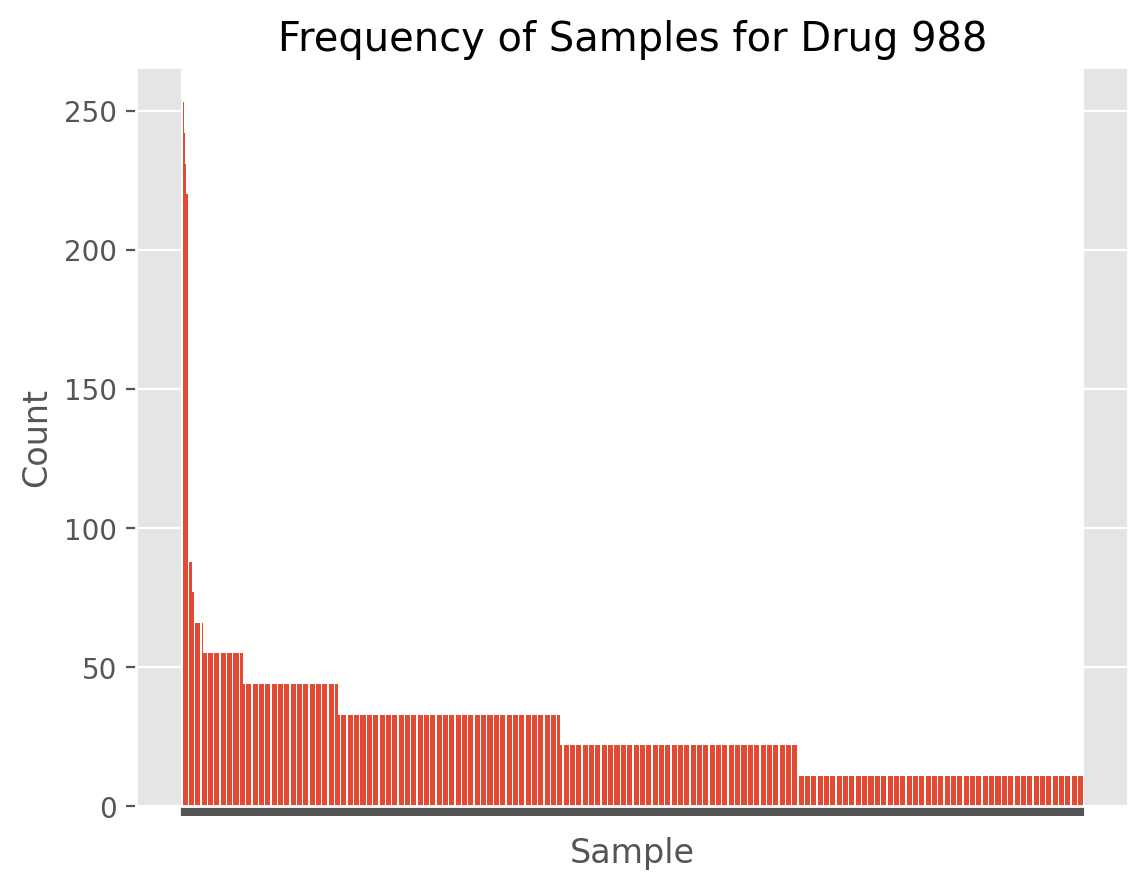

In [116]:
fig, ax = plt.subplots()

ax.bar(samples_df["Sample"], samples_df["Count"])

ax.set_xticklabels([], rotation = 45)
ax.set_ylabel("Count")
ax.set_xlabel("Sample")
ax.set_title("Frequency of Samples for Drug 988")

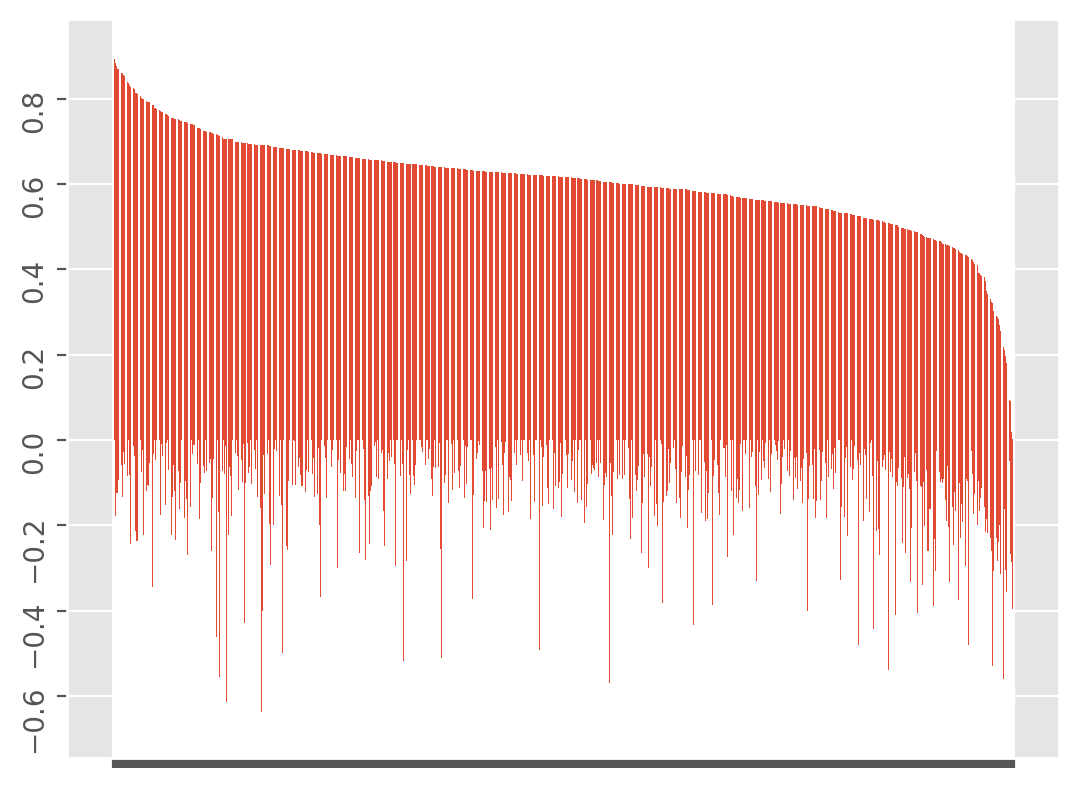

In [117]:
fig, ax = plt.subplots()
# fig.
srted = df_988_worst_tumor.sort_values("AUCError", ascending=False)
ax.bar(x = pd.Categorical(srted["Sample"]), height=srted["AUCError"], width=0.7)
ax.set_xticklabels([])
ax.tick_params(labelrotation=90)

Additional Questions:
- What is the actual data getting fed to the model?
- What else would you like me to look at?